importing libraries

import libraryies


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.models import Model

dataset_path = "/content/drive/MyDrive/kaggle_3m"

def load_brain_mri_data(dataset_path, num_folders=40, img_size=(128, 128)):
    """
    Load and preprocess brain MRI data in one function
    """
    images = []
    masks = []
    filenames = []

    print(f"Loading first {num_folders} folders...")
    patient_folders = sorted(os.listdir(dataset_path))[:num_folders]

    for i, folder in enumerate(patient_folders):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            files = sorted(os.listdir(folder_path))
            image_files = [f for f in files if not f.endswith('_mask.tif') and f.endswith('.tif')]

            for img_file in image_files:
                mask_file = img_file.replace('.tif', '_mask.tif')

                if mask_file in files:
                    # Load and preprocess image
                    img_path = os.path.join(folder_path, img_file)
                    image = cv2.imread(img_path)
                    image = cv2.resize(image, img_size)
                    image = image.astype('float32') / 255.0

                    # Load and preprocess mask
                    mask_path = os.path.join(folder_path, mask_file)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, img_size)
                    mask = (mask > 128).astype('float32')
                    mask = np.expand_dims(mask, axis=-1)

                    images.append(image)
                    masks.append(mask)
                    filenames.append(f"{folder}/{img_file}")

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{num_folders} folders")

    return np.array(images), np.array(masks), filenames

def split_dataset(images, masks, filenames, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split dataset into train, validation, and test sets
    """
    # First split: separate train+val from test
    X_temp, X_test, y_temp, y_test, names_temp, names_test = train_test_split(
        images, masks, filenames, test_size=test_ratio, random_state=42
    )

    # Second split: separate train from val
    val_size = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val, names_train, names_val = train_test_split(
        X_temp, y_temp, names_temp, test_size=val_size, random_state=42
    )

    print(f"Dataset split:")
    print(f"Training: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Load and preprocess data
print("Loading and preprocessing brain MRI data...")
images, masks, filenames = load_brain_mri_data(dataset_path, num_folders=40)

# Split the dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(images, masks, filenames)

print(f"\nFinal dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Loading and preprocessing brain MRI data...
Loading first 40 folders...
Processed 10/40 folders
Processed 20/40 folders
Processed 30/40 folders
Processed 40/40 folders
Dataset split:
Training: 1000 samples
Validation: 215 samples
Test: 215 samples

Final dataset shapes:
X_train: (1000, 128, 128, 3), y_train: (1000, 128, 128, 1)
X_val: (215, 128, 128, 3), y_val: (215, 128, 128, 1)
X_test: (215, 128, 128, 3), y_test: (215, 128, 128, 1)


i

In [2]:
def display_dataset_info(images, masks, filenames):
    print("\nDataset Information:")
    print("-" * 40)
    print(f"Total Images: {len(images)}")
    print(f"Image Shape: {images[0].shape}")
    print(f"Mask Shape: {masks[0].shape}")
    print(f"Image Range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Mask Range: [{masks.min():.3f}, {masks.max():.3f}]")

    mask_areas = []
    for mask in masks:
        mask_area = np.sum(mask > 0.5)
        mask_areas.append(mask_area)

    print(f"\nMask Area Statistics:")
    print(f"Average tumor area: {np.mean(mask_areas):.2f} pixels")
    print(f"Max tumor area: {np.max(mask_areas):.2f} pixels")
    print(f"Min tumor area: {np.min(mask_areas):.2f} pixels")
    print(f"Images with tumor: {np.mean([m > 0 for m in mask_areas]) * 100:.2f}%")

In [4]:
display_dataset_info(images, masks, filenames)


Dataset Information:
----------------------------------------
Total Images: 1430
Image Shape: (128, 128, 3)
Mask Shape: (128, 128, 1)
Image Range: [0.000, 0.992]
Mask Range: [0.000, 1.000]

Mask Area Statistics:
Average tumor area: 166.94 pixels
Max tumor area: 1835.00 pixels
Min tumor area: 0.00 pixels
Images with tumor: 34.41%


In [3]:
def visualize_samples(images, masks, filenames, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = images[idx]
        mask = masks[idx]

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original MRI\n{filenames[idx]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(img)
        axes[i, 2].imshow(mask.squeeze(), alpha=0.3, cmap='Reds')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

        hist_img = img.flatten()
        axes[i, 3].hist(hist_img, bins=50, alpha=0.7)
        axes[i, 3].set_title('Intensity Distribution')
        axes[i, 3].set_xlabel('Pixel Value')
        axes[i, 3].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


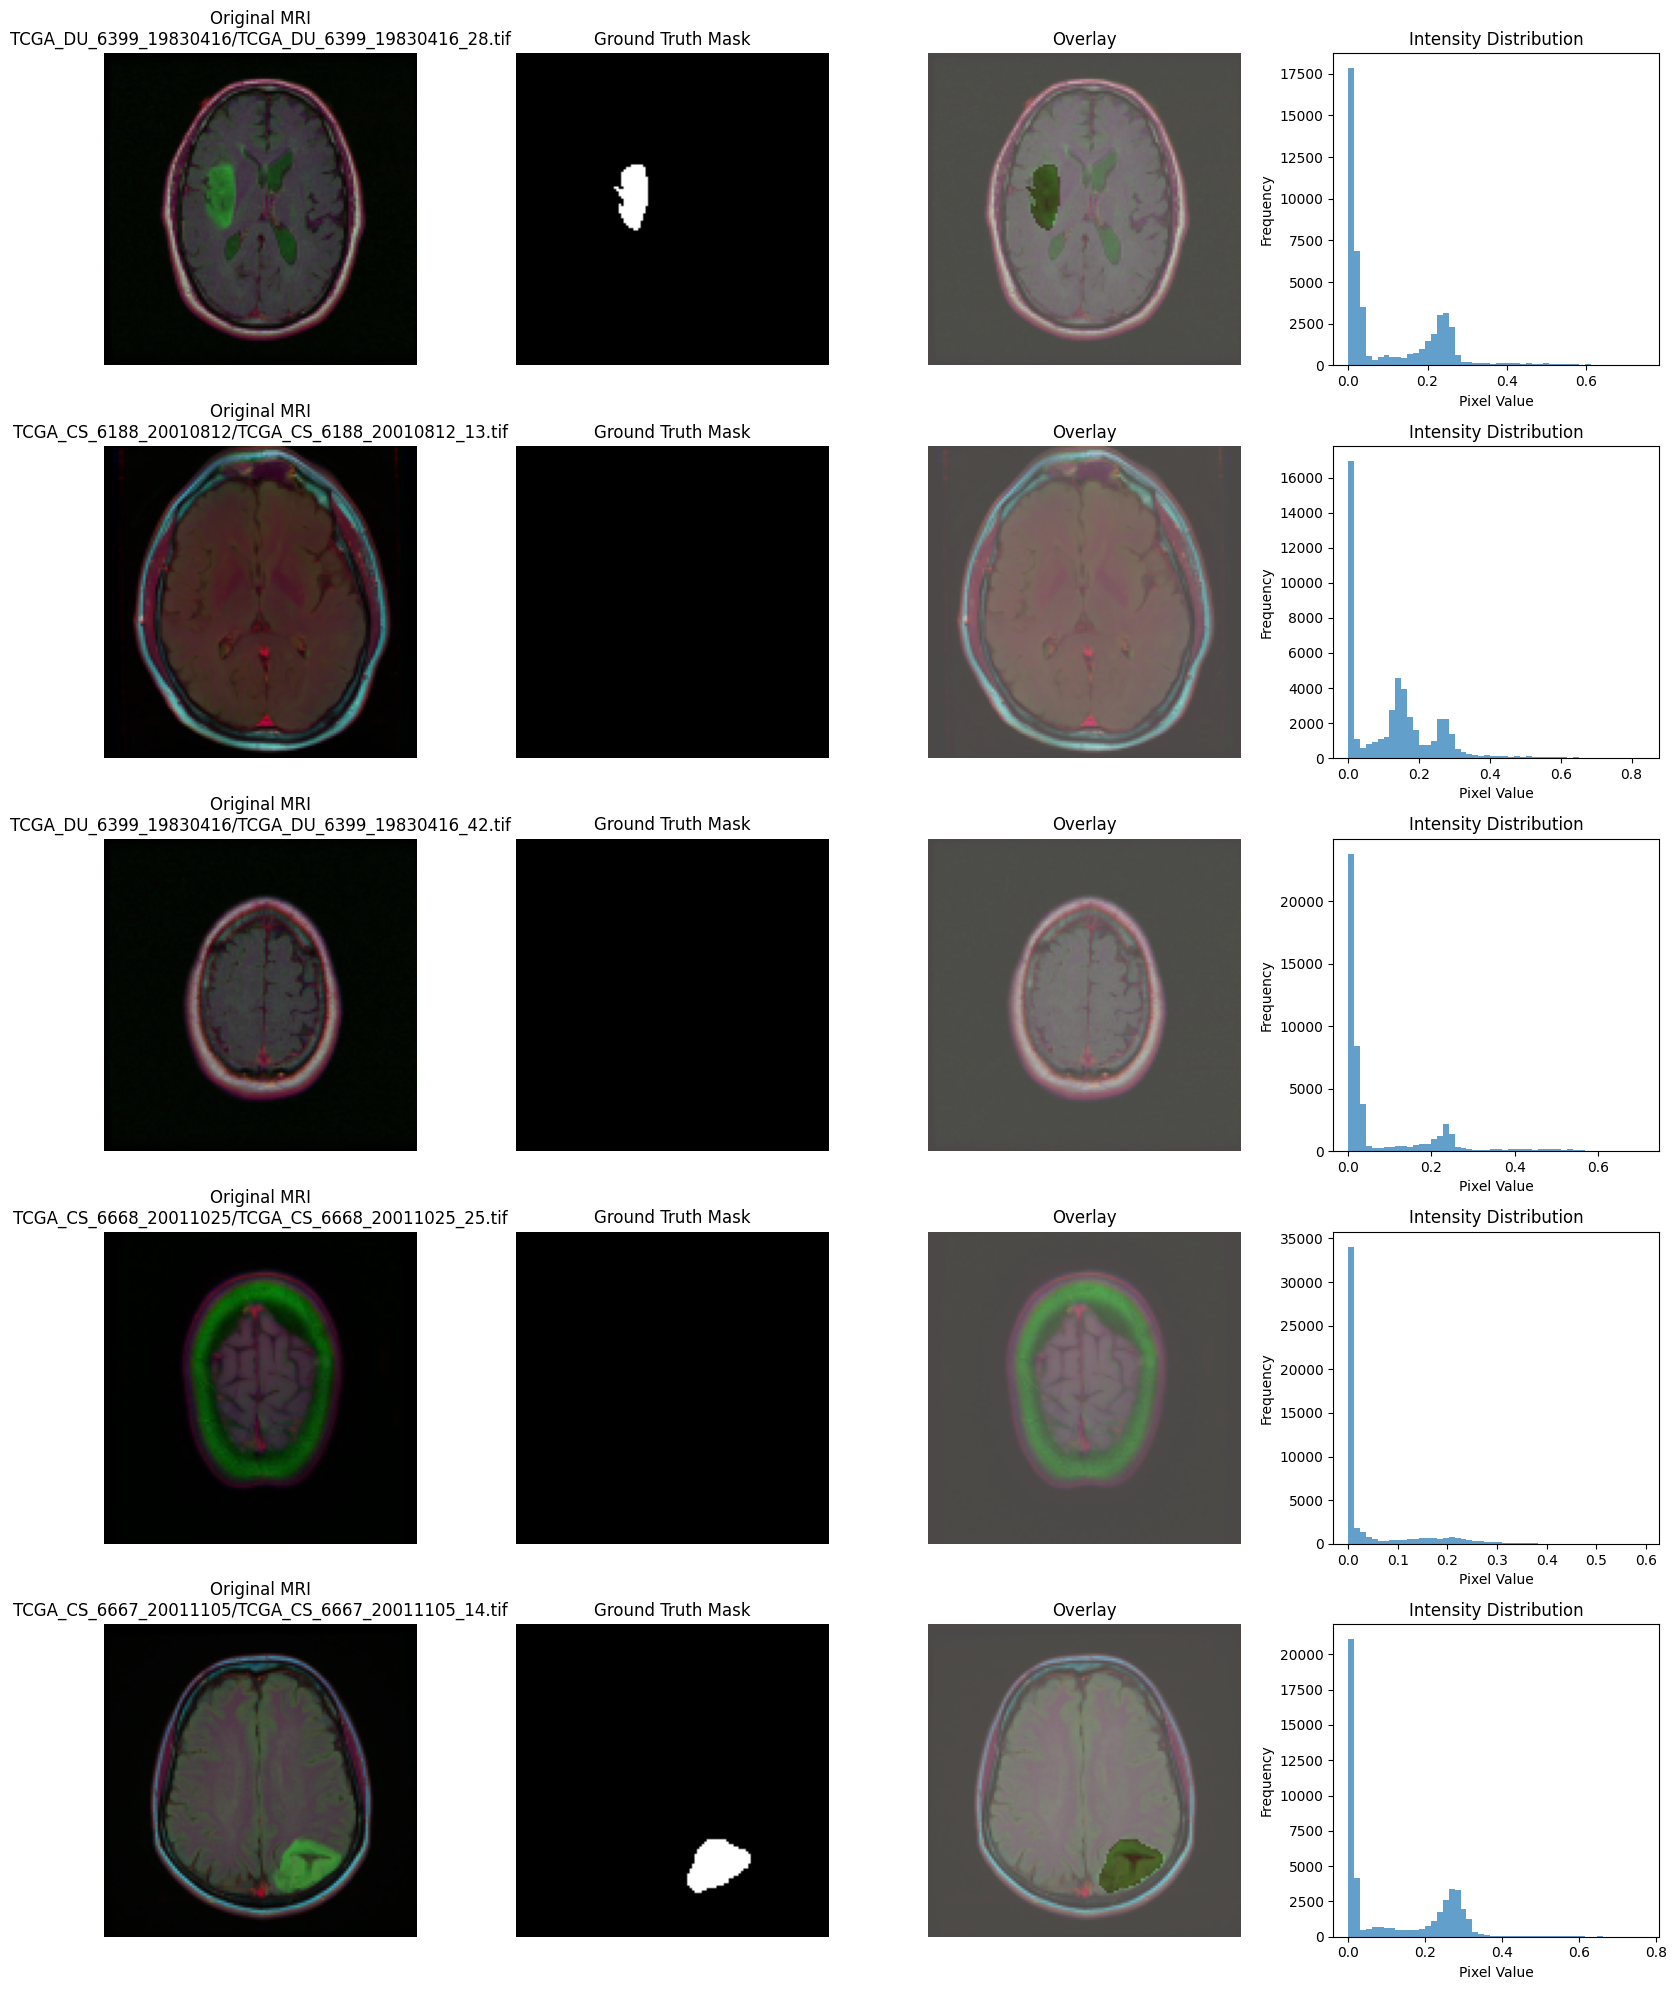

In [4]:
visualize_samples(images,masks,filenames,num_samples=5)

In [5]:
def plot_data_distribution(images, masks):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    mask_pixels = [np.sum(mask > 0.5) for mask in masks]
    axes[0].hist(mask_pixels, bins=30, alpha=0.7, color='blue')
    axes[0].set_xlabel('Tumor Area (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Tumor Size Distribution')
    axes[0].grid(True, alpha=0.3)

    mean_intensities = [np.mean(img) for img in images]
    axes[1].hist(mean_intensities, bins=30, alpha=0.7, color='green')
    axes[1].set_xlabel('Mean Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Image Intensity Distribution')
    axes[1].grid(True, alpha=0.3)

    tumor_presence = ['Tumor Present' if np.sum(mask) > 0 else 'No Tumor' for mask in masks]
    tumor_counts = pd.Series(tumor_presence).value_counts()
    axes[2].bar(tumor_counts.index, tumor_counts.values, color=['red', 'gray'])
    axes[2].set_ylabel('Count')
    axes[2].set_title('Tumor Presence Distribution')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

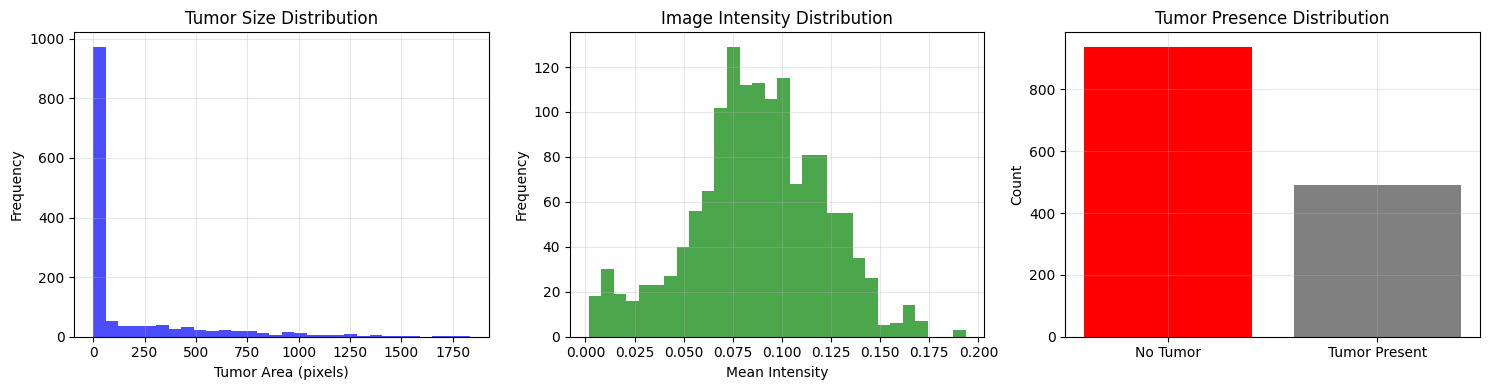

In [6]:
plot_data_distribution(images, masks)

In [7]:
def create_augmentation_pipeline():
    img_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    mask_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    return img_gen, mask_gen


In [8]:
def visualize_augmentation(images, masks, num_samples=4):
    img_gen, mask_gen = create_augmentation_pipeline()

    fig, axes = plt.subplots(num_samples, 4, figsize=(14, 4 * num_samples))
    seed = np.random.randint(1000)

    image_flow = img_gen.flow(images[:num_samples], batch_size=1, seed=seed)
    mask_flow = mask_gen.flow(masks[:num_samples], batch_size=1, seed=seed)

    for i in range(num_samples):
        aug_img = next(image_flow)[0]
        aug_mask = next(mask_flow)[0]

        # ⚠ Fix masks so they don’t blur or wash out
        aug_mask = (aug_mask > 0.4).astype('float32')

        # ⚠ Normalize for display only
        disp_img = np.clip(aug_img, 0, 1)

        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(disp_img)
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Original Mask")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(aug_mask.squeeze(), cmap='gray')
        axes[i, 3].set_title("Augmented Mask")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


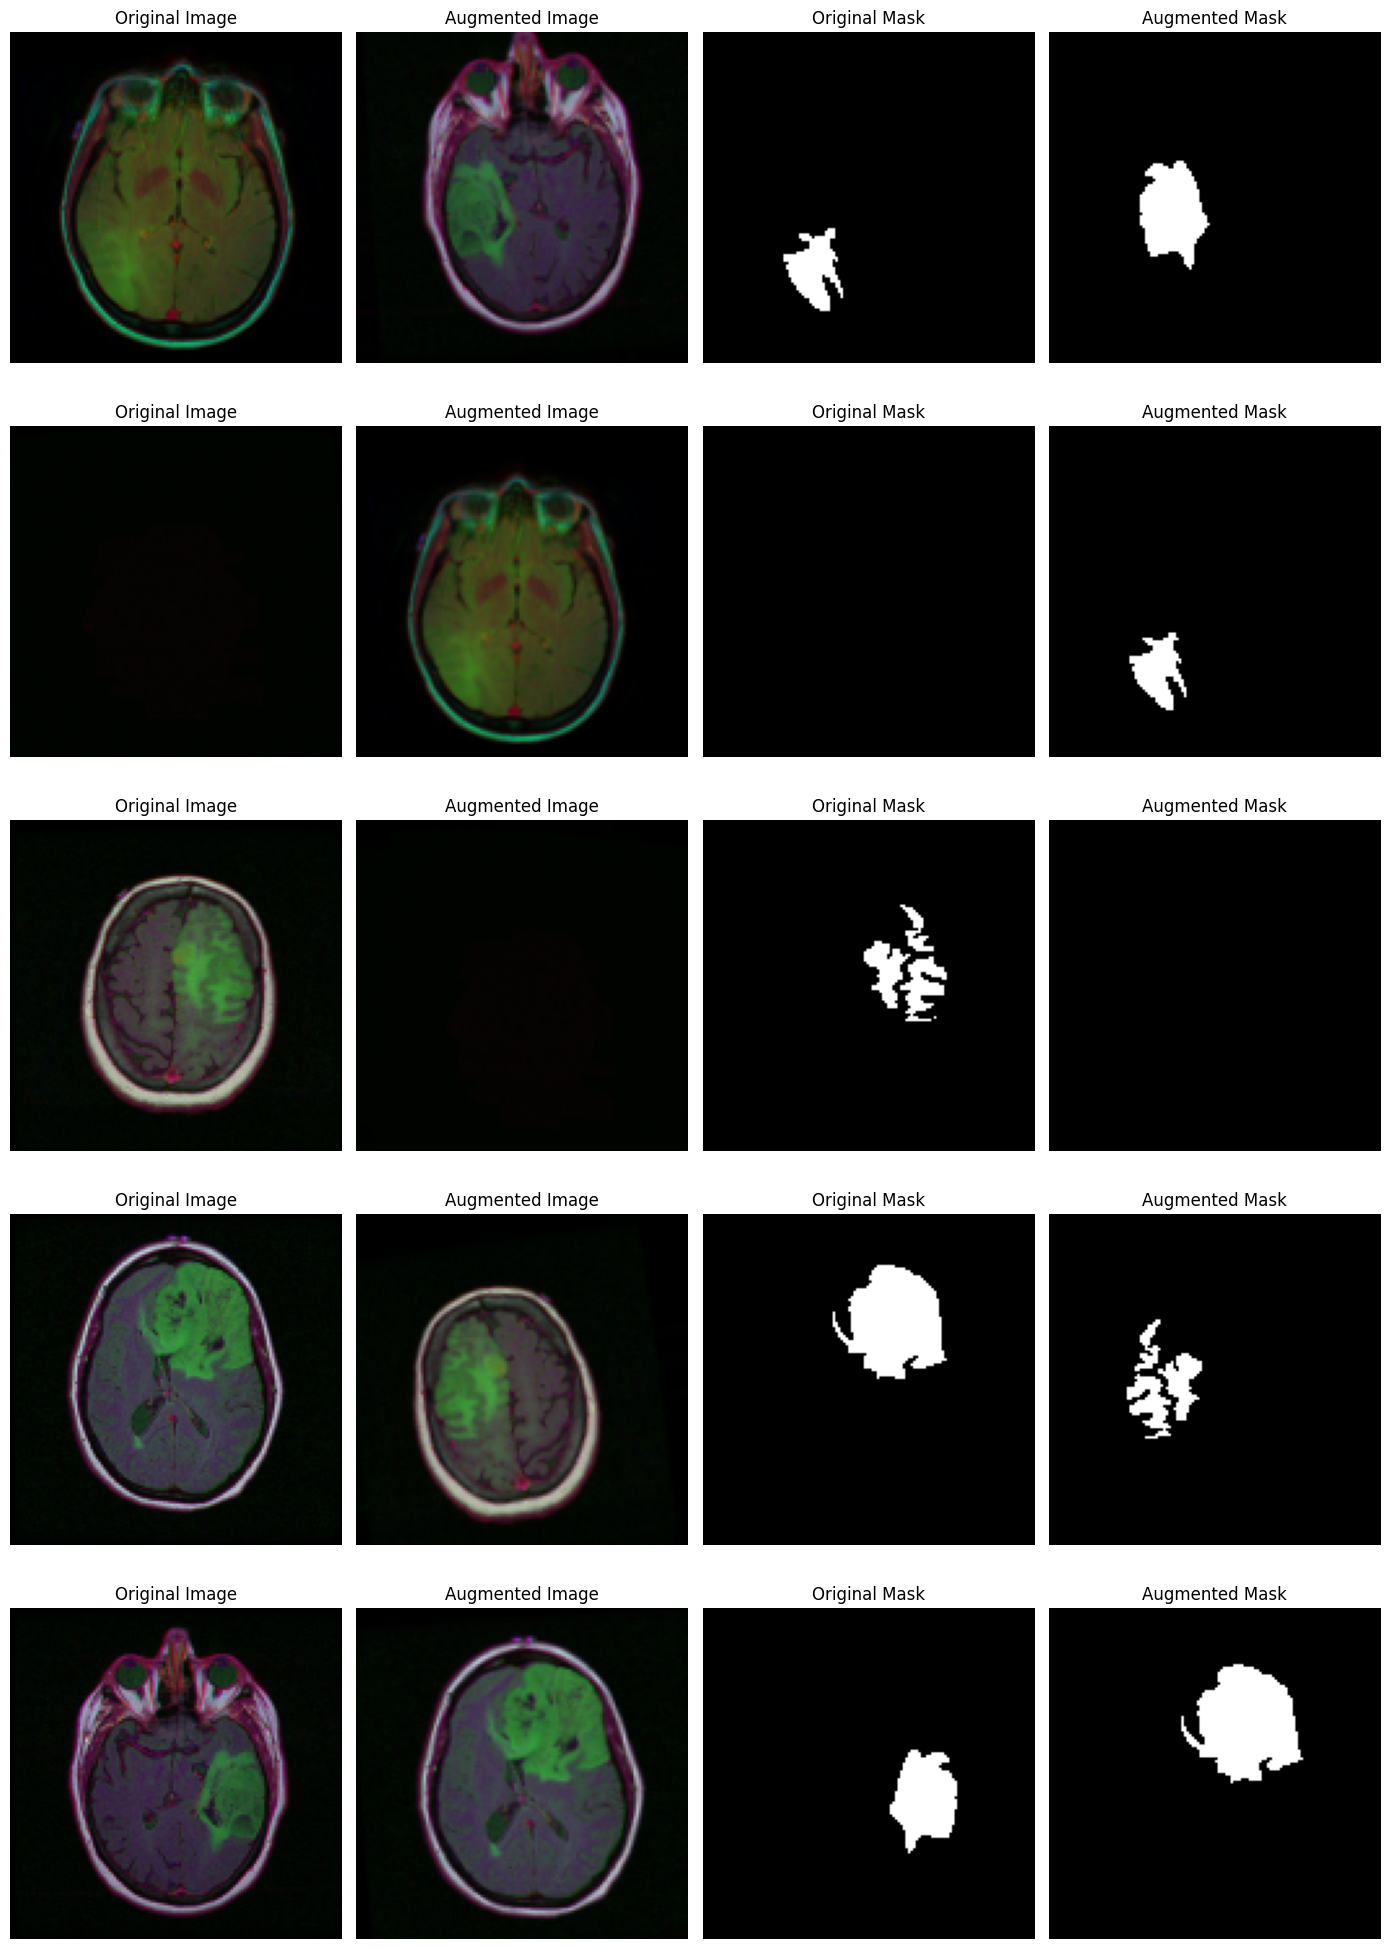

In [9]:
visualize_augmentation(X_train, y_train, num_samples=5)


i

In [10]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    def conv_block(x, filters, kernel_size=3):
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = conv_block(p3, 512)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = conv_block(u5, 256)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = conv_block(u6, 128)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = conv_block(u7, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model



In [11]:
uNet = build_unet(input_shape=(128, 128, 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [12]:
def build_resunet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    def residual_block(x, filters):
        shortcut = x

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)

        return x

    # Initial convolution
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Encoder
    x1 = residual_block(x, 64)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    # Bridge
    x4 = residual_block(p3, 512)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x4)
    u5 = layers.concatenate([u5, x3])
    x5 = residual_block(u5, 256)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x5)
    u6 = layers.concatenate([u6, x2])
    x6 = residual_block(u6, 128)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x6)
    u7 = layers.concatenate([u7, x1])
    x7 = residual_block(u7, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x7)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model


In [13]:
ResUnet=build_resunet()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ activation_16[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_17[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      8,320 │ max_pooling2d_3[

 Total params: 8,096,577 (30.89 MB)

 Trainable params: 8,088,129 (30.85 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [14]:
def build_deeplab_simple(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Atrous convolutions at different rates (simplified ASPP)
    rate1 = layers.Conv2D(128, 3, padding='same', dilation_rate=1)(x)
    rate1 = layers.BatchNormalization()(rate1)
    rate1 = layers.Activation('relu')(rate1)

    rate6 = layers.Conv2D(128, 3, padding='same', dilation_rate=6)(x)
    rate6 = layers.BatchNormalization()(rate6)
    rate6 = layers.Activation('relu')(rate6)

    rate12 = layers.Conv2D(128, 3, padding='same', dilation_rate=12)(x)
    rate12 = layers.BatchNormalization()(rate12)
    rate12 = layers.Activation('relu')(rate12)

    rate18 = layers.Conv2D(128, 3, padding='same', dilation_rate=18)(x)
    rate18 = layers.BatchNormalization()(rate18)
    rate18 = layers.Activation('relu')(rate18)

    # Concatenate all rates
    x = layers.concatenate([rate1, rate6, rate12, rate18])

    # Reduce channels
    x = layers.Conv2D(256, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Decoder
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

# Use this simpler version:
# DeepLab = build_deeplab_simple()

In [15]:
DeepLab=build_deeplab_simple()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_29[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 838,721 (3.20 MB)

 Trainable params: 836,545 (3.19 MB)

 Non-trainable params: 2,176 (8.50 KB)

i

In [16]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    """Plot Loss, Accuracy, Dice, and IoU curves"""
    metrics = ['loss', 'accuracy', 'dice_coefficient', 'iou_metric']
    titles = ['Loss', 'Accuracy', 'Dice Coefficient', 'IoU Score']

    plt.figure(figsize=(14, 10))

    for i, metric in enumerate(metrics):
        if metric in history.history:  # To avoid missing metric errors
            plt.subplot(2, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            plt.title(f'{model_name} - {titles[i]}')
            plt.xlabel('Epochs')
            plt.ylabel(titles[i])
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


i

In [18]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs, batch_size,learning_rate):
    print(f"\nTraining {model_name}...")
    print("-" * 40)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=bce_dice_loss,
        metrics=['accuracy', dice_coefficient, iou_metric]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    # Training with data augmentation
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    plot_training_history(history, model_name)

    return model, history


In [19]:
def evaluate_model(model, X_test, y_test, model_name, plot_curves=True):
    print(f"\nEvaluating {model_name}...")
    print("-" * 40)

    # Predict
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    # Flatten for sklearn metrics
    y_true_flat = y_test.reshape(-1).astype(np.int32)
    y_pred_flat = y_pred_binary.reshape(-1).astype(np.int32)
    y_pred_prob_flat = y_pred.reshape(-1)

    # Calculate metrics
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    iou = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")

    # Calculate dice score
    dice = dice_coefficient(
        tf.convert_to_tensor(y_test),
        tf.convert_to_tensor(y_pred_binary)
    )
    print(f"Dice Coefficient: {dice:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_prob_flat)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_flat, y_pred_prob_flat)
    pr_auc = auc(recall_curve, precision_curve)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Plot curves if requested
    if plot_curves:
        plot_single_model_curves(y_true_flat, y_pred_prob_flat, model_name, fpr, tpr, roc_auc, recall_curve, precision_curve, pr_auc)

    return {
        'model_name': model_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou,
        'dice': float(dice),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

def plot_single_model_curves(y_true, y_pred_prob, model_name, fpr, tpr, roc_auc, recall_curve, precision_curve, pr_auc):
    """Plot ROC and PR curves for a single model"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'{model_name} - ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)

    # Precision-Recall Curve
    axes[1].plot(recall_curve, precision_curve, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'{model_name} - Precision-Recall Curve')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_roc_curves(all_metrics, y_test):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 6))

    for metrics in all_metrics:
        y_true_flat = y_test.reshape(-1).astype(np.int32)
        y_pred_prob_flat = metrics['y_pred'].reshape(-1)

        fpr, tpr, _ = roc_curve(y_true_flat, y_pred_prob_flat)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{metrics['model_name']} (AUC = {roc_auc:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_pr_curves(all_metrics, y_test):
    """Plot Precision-Recall curves for multiple models"""
    plt.figure(figsize=(10, 6))

    for metrics in all_metrics:
        y_true_flat = y_test.reshape(-1).astype(np.int32)
        y_pred_prob_flat = metrics['y_pred'].reshape(-1)

        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_prob_flat)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, label=f"{metrics['model_name']} (AUC = {pr_auc:.3f})", linewidth=2)

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves - Model Comparison', fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

In [20]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_curve, auc,
    jaccard_score, precision_recall_curve
)



Training uNet...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9401 - dice_coefficient: 0.0487 - iou_metric: 0.0251 - loss: 1.2696
Epoch 1: val_dice_coefficient improved from -inf to 0.02181, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 918ms/step - accuracy: 0.9409 - dice_coefficient: 0.0492 - iou_metric: 0.0254 - loss: 1.2673 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0218 - val_iou_metric: 0.0110 - val_loss: 1.5686 - learning_rate: 1.0000e-04
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9902 - dice_coefficient: 0.1182 - iou_metric: 0.0631 - loss: 1.0217
Epoch 2: val_dice_coefficient improved from 0.02181 to 0.02315, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9902 - dice_coefficient: 0.1192 - iou_metric: 0.0637 - loss: 1.0198 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0231 - val_iou_metric: 0.0117 - val_loss: 1.4514 - learning_rate: 1.0000e-04
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9934 - dice_coefficient: 0.2003 - iou_metric: 0.1125 - loss: 0.8827
Epoch 3: val_dice_coefficient improved from 0.02315 to 0.02561, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9934 - dice_coefficient: 0.2010 - iou_metric: 0.1130 - loss: 0.8820 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0256 - val_iou_metric: 0.0130 - val_loss: 1.3764 - learning_rate: 1.0000e-04
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9933 - dice_coefficient: 0.2511 - iou_metric: 0.1447 - loss: 0.8196
Epoch 4: val_dice_coefficient improved from 0.02561 to 0.02650, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9933 - dice_coefficient: 0.2514 - iou_metric: 0.1450 - loss: 0.8191 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0265 - val_iou_metric: 0.0134 - val_loss: 1.2821 - learning_rate: 1.0000e-04
Epoch 5/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9933 - dice_coefficient: 0.2848 - iou_metric: 0.1669 - loss: 0.7784
Epoch 5: val_dice_coefficient did not improve from 0.02650
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9933 - dice_coefficient: 0.2853 - iou_metric: 0.1673 - loss: 0.7779 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0242 - val_iou_metric: 0.0122 - val_loss: 1.1921 - learning_rate: 1.0000e-04
Epoch 6/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9955 - dice_coefficient: 0.3214 - iou_metric: 0.1960 - loss: 0.7292
Epoch 6: val_dice_coefficient did not improve from 0.02650
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9955 - dice_coefficient: 0.3215 - iou_metric: 0.1960 - loss: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9964 - dice_coefficient: 0.4128 - iou_metric: 0.2661 - loss: 0.6232 - val_accuracy: 0.9895 - val_dice_coefficient: 0.0354 - val_iou_metric: 0.0181 - val_loss: 1.0414 - learning_rate: 1.0000e-04
Epoch 10/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9968 - dice_coefficient: 0.3942 - iou_metric: 0.2499 - loss: 0.6396
Epoch 10: val_dice_coefficient improved from 0.03545 to 0.06321, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9968 - dice_coefficient: 0.3967 - iou_metric: 0.2519 - loss: 0.6372 - val_accuracy: 0.9902 - val_dice_coefficient: 0.0632 - val_iou_metric: 0.0328 - val_loss: 1.0027 - learning_rate: 1.0000e-04
Epoch 11/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9973 - dice_coefficient: 0.4397 - iou_metric: 0.2865 - loss: 0.5891
Epoch 11: val_dice_coefficient improved from 0.06321 to 0.12833, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9973 - dice_coefficient: 0.4412 - iou_metric: 0.2877 - loss: 0.5876 - val_accuracy: 0.9912 - val_dice_coefficient: 0.1283 - val_iou_metric: 0.0692 - val_loss: 0.9238 - learning_rate: 1.0000e-04
Epoch 12/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9971 - dice_coefficient: 0.5035 - iou_metric: 0.3391 - loss: 0.5241
Epoch 12: val_dice_coefficient improved from 0.12833 to 0.15286, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9971 - dice_coefficient: 0.5030 - iou_metric: 0.3388 - loss: 0.5247 - val_accuracy: 0.9913 - val_dice_coefficient: 0.1529 - val_iou_metric: 0.0835 - val_loss: 0.8948 - learning_rate: 1.0000e-04
Epoch 13/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9972 - dice_coefficient: 0.5351 - iou_metric: 0.3700 - loss: 0.4898
Epoch 13: val_dice_coefficient improved from 0.15286 to 0.22176, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9972 - dice_coefficient: 0.5342 - iou_metric: 0.3691 - loss: 0.4905 - val_accuracy: 0.9920 - val_dice_coefficient: 0.2218 - val_iou_metric: 0.1260 - val_loss: 0.8184 - learning_rate: 1.0000e-04
Epoch 14/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9976 - dice_coefficient: 0.5635 - iou_metric: 0.3967 - loss: 0.4573
Epoch 14: val_dice_coefficient improved from 0.22176 to 0.24337, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9976 - dice_coefficient: 0.5618 - iou_metric: 0.3952 - loss: 0.4589 - val_accuracy: 0.9922 - val_dice_coefficient: 0.2434 - val_iou_metric: 0.1400 - val_loss: 0.7963 - learning_rate: 1.0000e-04
Epoch 15/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9979 - dice_coefficient: 0.5445 - iou_metric: 0.3779 - loss: 0.4749
Epoch 15: val_dice_coefficient improved from 0.24337 to 0.31793, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9979 - dice_coefficient: 0.5461 - iou_metric: 0.3794 - loss: 0.4734 - val_accuracy: 0.9931 - val_dice_coefficient: 0.3179 - val_iou_metric: 0.1918 - val_loss: 0.7168 - learning_rate: 1.0000e-04
Epoch 16/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9979 - dice_coefficient: 0.5781 - iou_metric: 0.4101 - loss: 0.4406
Epoch 16: val_dice_coefficient improved from 0.31793 to 0.40757, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9979 - dice_coefficient: 0.5790 - iou_metric: 0.4110 - loss: 0.4395 - val_accuracy: 0.9939 - val_dice_coefficient: 0.4076 - val_iou_metric: 0.2587 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 17/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9976 - dice_coefficient: 0.5955 - iou_metric: 0.4313 - loss: 0.4236
Epoch 17: val_dice_coefficient improved from 0.40757 to 0.48193, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9976 - dice_coefficient: 0.5956 - iou_metric: 0.4314 - loss: 0.4235 - val_accuracy: 0.9951 - val_dice_coefficient: 0.4819 - val_iou_metric: 0.3202 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 18/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9980 - dice_coefficient: 0.6268 - iou_metric: 0.4611 - loss: 0.3892
Epoch 18: val_dice_coefficient improved from 0.48193 to 0.54108, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9980 - dice_coefficient: 0.6271 - iou_metric: 0.4615 - loss: 0.3891 - val_accuracy: 0.9961 - val_dice_coefficient: 0.5411 - val_iou_metric: 0.3725 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 19/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9981 - dice_coefficient: 0.6634 - iou_metric: 0.4983 - loss: 0.3512
Epoch 19: val_dice_coefficient improved from 0.54108 to 0.60065, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9981 - dice_coefficient: 0.6621 - iou_metric: 0.4973 - loss: 0.3517 - val_accuracy: 0.9966 - val_dice_coefficient: 0.6006 - val_iou_metric: 0.4311 - val_loss: 0.4187 - learning_rate: 1.0000e-04
Epoch 20/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9980 - dice_coefficient: 0.6635 - iou_metric: 0.4997 - loss: 0.3518
Epoch 20: val_dice_coefficient did not improve from 0.60065
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9980 - dice_coefficient: 0.6630 - iou_metric: 0.4994 - loss: 0.3516 - val_accuracy: 0.9962 - val_dice_coefficient: 0.5983 - val_iou_metric: 0.4282 - val_loss: 0.4233 - learning_rate: 1.0000e-04
Epoch 21/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9980 - dice_coefficient: 0.6916 - iou_metric: 0.5327 - loss: 0.3231
Epoch 21: val_dice_coefficient improved from 0.60065 to 0.62986, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9980 - dice_coefficient: 0.6906 - iou_metric: 0.5315 - loss: 0.3238 - val_accuracy: 0.9963 - val_dice_coefficient: 0.6299 - val_iou_metric: 0.4615 - val_loss: 0.3921 - learning_rate: 1.0000e-04
Epoch 22/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9976 - dice_coefficient: 0.6894 - iou_metric: 0.5280 - loss: 0.3258
Epoch 22: val_dice_coefficient improved from 0.62986 to 0.64634, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9977 - dice_coefficient: 0.6893 - iou_metric: 0.5280 - loss: 0.3257 - val_accuracy: 0.9970 - val_dice_coefficient: 0.6463 - val_iou_metric: 0.4794 - val_loss: 0.3691 - learning_rate: 1.0000e-04
Epoch 23/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9980 - dice_coefficient: 0.7067 - iou_metric: 0.5506 - loss: 0.3067
Epoch 23: val_dice_coefficient improved from 0.64634 to 0.67497, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9980 - dice_coefficient: 0.7065 - iou_metric: 0.5504 - loss: 0.3065 - val_accuracy: 0.9972 - val_dice_coefficient: 0.6750 - val_iou_metric: 0.5110 - val_loss: 0.3388 - learning_rate: 1.0000e-04
Epoch 24/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9977 - dice_coefficient: 0.7212 - iou_metric: 0.5694 - loss: 0.2939
Epoch 24: val_dice_coefficient did not improve from 0.67497
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9978 - dice_coefficient: 0.7203 - iou_metric: 0.5684 - loss: 0.2946 - val_accuracy: 0.9970 - val_dice_coefficient: 0.6733 - val_iou_metric: 0.5086 - val_loss: 0.3426 - learning_rate: 1.0000e-04
Epoch 25/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9983 - dice_coefficient: 0.7188 - iou_metric: 0.5650 - loss: 0.2928
Epoch 25: val_dice_coefficient improved from 0.67497 to 0.70821, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9983 - dice_coefficient: 0.7197 - iou_metric: 0.5662 - loss: 0.2920 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7082 - val_iou_metric: 0.5496 - val_loss: 0.3066 - learning_rate: 1.0000e-04
Epoch 26/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9984 - dice_coefficient: 0.7566 - iou_metric: 0.6118 - loss: 0.2540
Epoch 26: val_dice_coefficient improved from 0.70821 to 0.72622, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9984 - dice_coefficient: 0.7567 - iou_metric: 0.6119 - loss: 0.2540 - val_accuracy: 0.9974 - val_dice_coefficient: 0.7262 - val_iou_metric: 0.5714 - val_loss: 0.2871 - learning_rate: 1.0000e-04
Epoch 27/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9982 - dice_coefficient: 0.7635 - iou_metric: 0.6204 - loss: 0.2477
Epoch 27: val_dice_coefficient improved from 0.72622 to 0.72689, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9982 - dice_coefficient: 0.7637 - iou_metric: 0.6206 - loss: 0.2477 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7269 - val_iou_metric: 0.5725 - val_loss: 0.2870 - learning_rate: 1.0000e-04
Epoch 28/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9985 - dice_coefficient: 0.7875 - iou_metric: 0.6524 - loss: 0.2218
Epoch 28: val_dice_coefficient improved from 0.72689 to 0.75125, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9985 - dice_coefficient: 0.7872 - iou_metric: 0.6520 - loss: 0.2222 - val_accuracy: 0.9975 - val_dice_coefficient: 0.7513 - val_iou_metric: 0.6028 - val_loss: 0.2626 - learning_rate: 1.0000e-04
Epoch 29/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9986 - dice_coefficient: 0.8057 - iou_metric: 0.6754 - loss: 0.2030
Epoch 29: val_dice_coefficient improved from 0.75125 to 0.76075, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9986 - dice_coefficient: 0.8054 - iou_metric: 0.6750 - loss: 0.2032 - val_accuracy: 0.9976 - val_dice_coefficient: 0.7607 - val_iou_metric: 0.6151 - val_loss: 0.2508 - learning_rate: 1.0000e-04
Epoch 30/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9987 - dice_coefficient: 0.8036 - iou_metric: 0.6751 - loss: 0.2040
Epoch 30: val_dice_coefficient improved from 0.76075 to 0.77880, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9987 - dice_coefficient: 0.8036 - iou_metric: 0.6751 - loss: 0.2042 - val_accuracy: 0.9976 - val_dice_coefficient: 0.7788 - val_iou_metric: 0.6389 - val_loss: 0.2326 - learning_rate: 1.0000e-04
Epoch 31/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9987 - dice_coefficient: 0.7938 - iou_metric: 0.6645 - loss: 0.2142
Epoch 31: val_dice_coefficient did not improve from 0.77880
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9987 - dice_coefficient: 0.7946 - iou_metric: 0.6655 - loss: 0.2133 - val_accuracy: 0.9973 - val_dice_coefficient: 0.7682 - val_iou_metric: 0.6248 - val_loss: 0.2446 - learning_rate: 1.0000e-04
Epoch 32/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9988 - dice_coefficient: 0.8204 - iou_metric: 0.6973 - loss: 0.1869
Epoch 32: val_dice_coefficient did not improve from 0.77880
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9988 - dice_coefficient: 0.8207 - iou_metric: 0.6978 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9987 - dice_coefficient: 0.8351 - iou_metric: 0.7186 - loss: 0.1725 - val_accuracy: 0.9974 - val_dice_coefficient: 0.7903 - val_iou_metric: 0.6548 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 35/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9989 - dice_coefficient: 0.8326 - iou_metric: 0.7180 - loss: 0.1738
Epoch 35: val_dice_coefficient improved from 0.79033 to 0.79229, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9989 - dice_coefficient: 0.8332 - iou_metric: 0.7189 - loss: 0.1732 - val_accuracy: 0.9975 - val_dice_coefficient: 0.7923 - val_iou_metric: 0.6573 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 36/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9990 - dice_coefficient: 0.8575 - iou_metric: 0.7523 - loss: 0.1484
Epoch 36: val_dice_coefficient improved from 0.79229 to 0.80069, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9990 - dice_coefficient: 0.8574 - iou_metric: 0.7521 - loss: 0.1486 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8007 - val_iou_metric: 0.6689 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 37/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9990 - dice_coefficient: 0.8686 - iou_metric: 0.7691 - loss: 0.1370
Epoch 37: val_dice_coefficient improved from 0.80069 to 0.81078, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9990 - dice_coefficient: 0.8682 - iou_metric: 0.7685 - loss: 0.1374 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8108 - val_iou_metric: 0.6827 - val_loss: 0.2024 - learning_rate: 1.0000e-04
Epoch 38/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9990 - dice_coefficient: 0.8722 - iou_metric: 0.7746 - loss: 0.1338
Epoch 38: val_dice_coefficient improved from 0.81078 to 0.81123, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9990 - dice_coefficient: 0.8719 - iou_metric: 0.7742 - loss: 0.1341 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8112 - val_iou_metric: 0.6835 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 39/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9991 - dice_coefficient: 0.8725 - iou_metric: 0.7757 - loss: 0.1325
Epoch 39: val_dice_coefficient improved from 0.81123 to 0.81495, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9991 - dice_coefficient: 0.8726 - iou_metric: 0.7758 - loss: 0.1324 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8149 - val_iou_metric: 0.6888 - val_loss: 0.1961 - learning_rate: 1.0000e-04
Epoch 40/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9991 - dice_coefficient: 0.8714 - iou_metric: 0.7739 - loss: 0.1333
Epoch 40: val_dice_coefficient did not improve from 0.81495
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9991 - dice_coefficient: 0.8719 - iou_metric: 0.7746 - loss: 0.1329 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8144 - val_iou_metric: 0.6880 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 41/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9992 - dice_coefficient: 0.8900 - iou_metric: 0.8026 - loss: 0.1145
Epoch 41: val_dice_coefficient improved from 0.81495 to 0.82011, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9992 - dice_coefficient: 0.8897 - iou_metric: 0.8021 - loss: 0.1147 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8201 - val_iou_metric: 0.6962 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 42/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9992 - dice_coefficient: 0.8827 - iou_metric: 0.7923 - loss: 0.1220
Epoch 42: val_dice_coefficient improved from 0.82011 to 0.82392, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9992 - dice_coefficient: 0.8828 - iou_metric: 0.7927 - loss: 0.1215 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8239 - val_iou_metric: 0.7015 - val_loss: 0.1884 - learning_rate: 1.0000e-04
Epoch 43/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9991 - dice_coefficient: 0.8936 - iou_metric: 0.8091 - loss: 0.1113
Epoch 43: val_dice_coefficient improved from 0.82392 to 0.82509, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9991 - dice_coefficient: 0.8932 - iou_metric: 0.8083 - loss: 0.1116 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8251 - val_iou_metric: 0.7035 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 44/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9992 - dice_coefficient: 0.8880 - iou_metric: 0.8010 - loss: 0.1165
Epoch 44: val_dice_coefficient improved from 0.82509 to 0.82510, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9992 - dice_coefficient: 0.8882 - iou_metric: 0.8012 - loss: 0.1163 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8251 - val_iou_metric: 0.7034 - val_loss: 0.1876 - learning_rate: 1.0000e-04
Epoch 45/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9992 - dice_coefficient: 0.8954 - iou_metric: 0.8132 - loss: 0.1089
Epoch 45: val_dice_coefficient improved from 0.82510 to 0.82944, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9992 - dice_coefficient: 0.8955 - iou_metric: 0.8134 - loss: 0.1088 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8294 - val_iou_metric: 0.7099 - val_loss: 0.1829 - learning_rate: 1.0000e-04
Epoch 46/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9992 - dice_coefficient: 0.9083 - iou_metric: 0.8326 - loss: 0.0961
Epoch 46: val_dice_coefficient improved from 0.82944 to 0.83373, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9992 - dice_coefficient: 0.9082 - iou_metric: 0.8324 - loss: 0.0962 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8337 - val_iou_metric: 0.7161 - val_loss: 0.1780 - learning_rate: 1.0000e-04
Epoch 47/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9993 - dice_coefficient: 0.9081 - iou_metric: 0.8324 - loss: 0.0958
Epoch 47: val_dice_coefficient did not improve from 0.83373
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9993 - dice_coefficient: 0.9066 - iou_metric: 0.8312 - loss: 0.0959 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8253 - val_iou_metric: 0.7039 - val_loss: 0.1861 - learning_rate: 1.0000e-04
Epoch 48/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9994 - dice_coefficient: 0.9133 - iou_metric: 0.8415 - loss: 0.0901
Epoch 48: val_dice_coefficient improved from 0.83373 to 0.84051, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9994 - dice_coefficient: 0.9132 - iou_metric: 0.8413 - loss: 0.0902 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8405 - val_iou_metric: 0.7262 - val_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 49/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9994 - dice_coefficient: 0.9203 - iou_metric: 0.8529 - loss: 0.0831
Epoch 49: val_dice_coefficient improved from 0.84051 to 0.84198, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9994 - dice_coefficient: 0.9202 - iou_metric: 0.8528 - loss: 0.0831 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8420 - val_iou_metric: 0.7282 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 50/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9993 - dice_coefficient: 0.9192 - iou_metric: 0.8510 - loss: 0.0844
Epoch 50: val_dice_coefficient did not improve from 0.84198
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9993 - dice_coefficient: 0.9193 - iou_metric: 0.8511 - loss: 0.0843 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8370 - val_iou_metric: 0.7210 - val_loss: 0.1762 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 49.


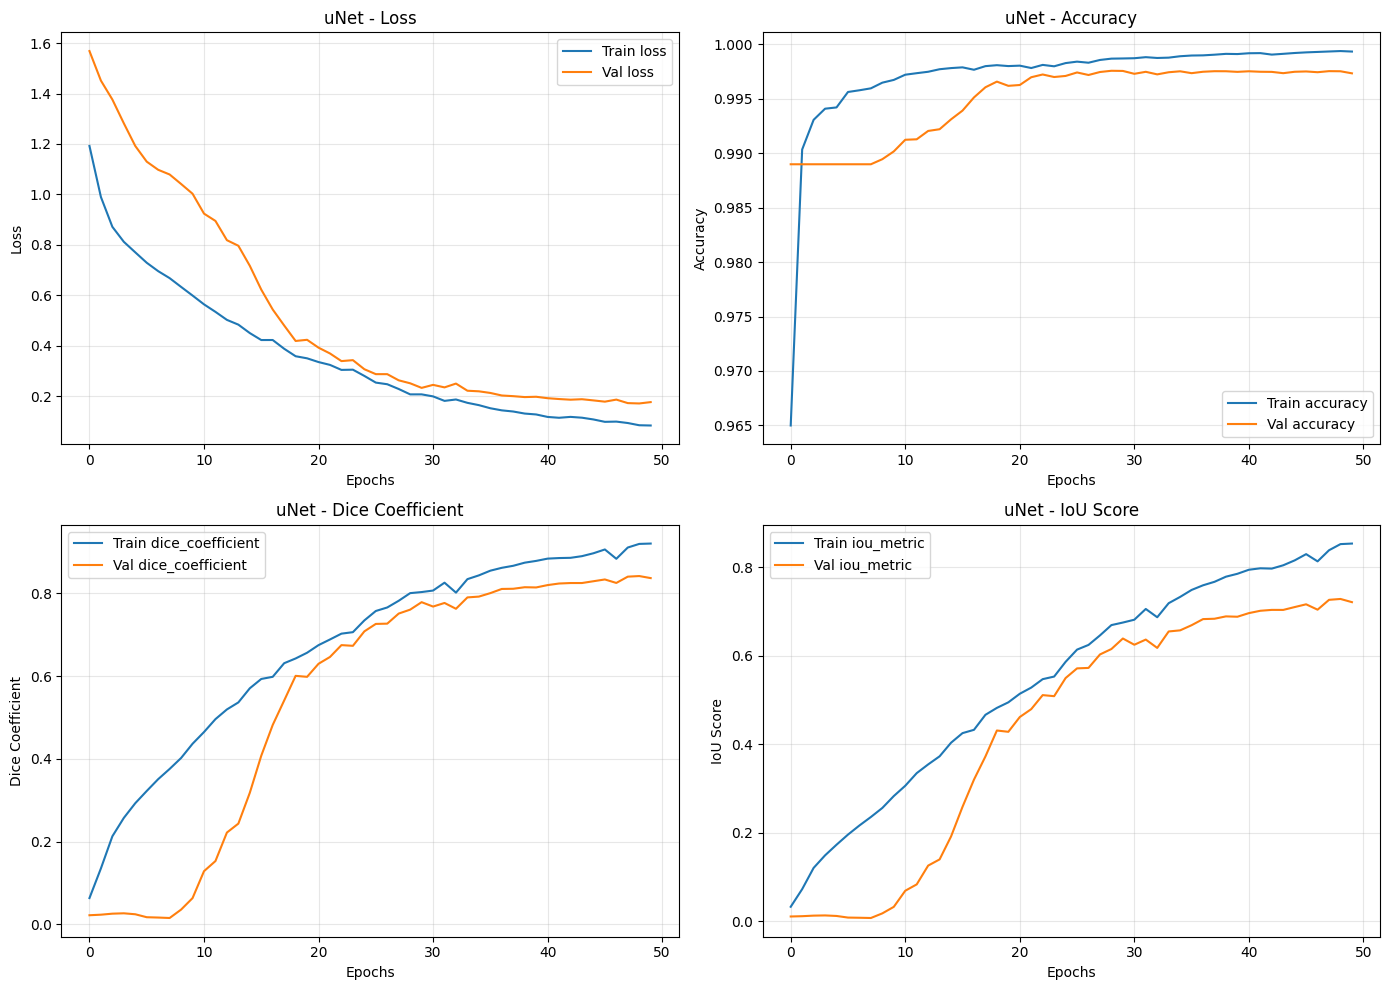

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7a10928d7d70>)

In [21]:
train_model(uNet, X_train, y_train, X_val, y_val, model_name='uNet', epochs=50, batch_size=32,learning_rate=1e-4)


Evaluating UNet...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step
Precision: 0.9024
Recall: 0.8474
F1-Score: 0.8741
IoU: 0.7763
Dice Coefficient: 0.8741
ROC AUC: 0.9625
PR AUC: 0.9020


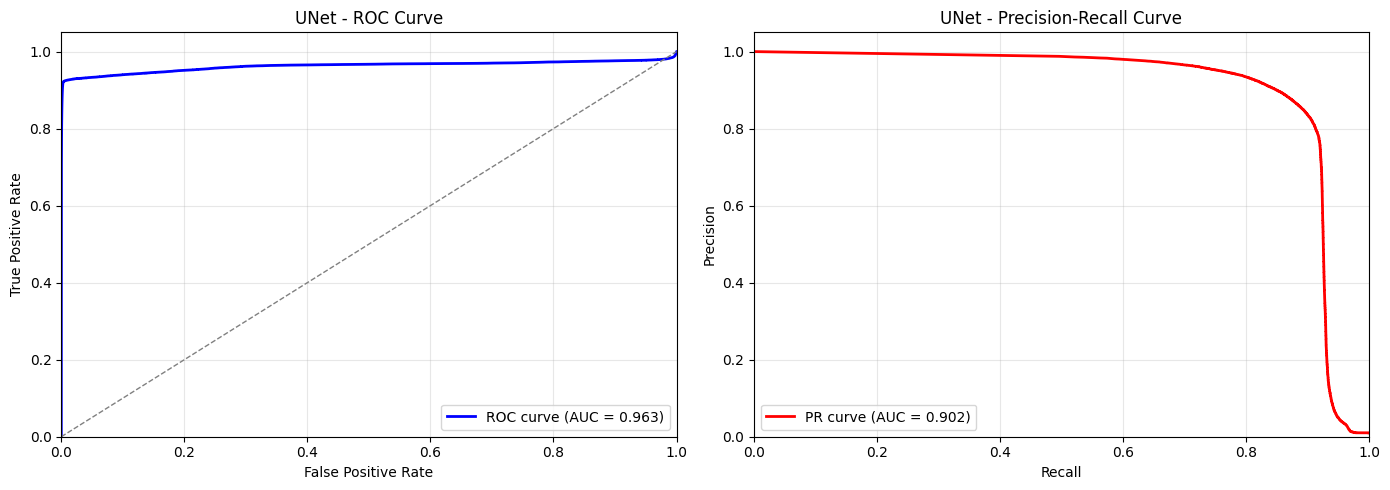

In [22]:
# This will show plots immediately
uNet_metrics = evaluate_model(uNet, X_test, y_test, model_name='UNet', plot_curves=True)


Training uNet...
----------------------------------------
Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9975 - dice_coefficient: 0.8344 - iou_metric: 0.7262 - loss: 0.1800
Epoch 1: val_dice_coefficient improved from -inf to 0.69902, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - accuracy: 0.9975 - dice_coefficient: 0.8338 - iou_metric: 0.7254 - loss: 0.1807 - val_accuracy: 0.9932 - val_dice_coefficient: 0.6990 - val_iou_metric: 0.5433 - val_loss: 0.3480 - learning_rate: 3.0000e-04
Epoch 2/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9964 - dice_coefficient: 0.7436 - iou_metric: 0.6134 - loss: 0.2797
Epoch 2: val_dice_coefficient did not improve from 0.69902
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9964 - dice_coefficient: 0.7435 - iou_metric: 0.6133 - loss: 0.2799 - val_accuracy: 0.9932 - val_dice_coefficient: 0.6825 - val_iou_metric: 0.5240 - val_loss: 0.3392 - learning_rate: 3.0000e-04
Epoch 3/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9966 - dice_coefficient: 0.7560 - iou_metric: 0.6222 - loss: 0.2624
Epoch 3: val_dice_coefficient improved from 0.69902 to 0.78486, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9966 - dice_coefficient: 0.7564 - iou_metric: 0.6226 - loss: 0.2622 - val_accuracy: 0.9961 - val_dice_coefficient: 0.7849 - val_iou_metric: 0.6502 - val_loss: 0.2312 - learning_rate: 3.0000e-04
Epoch 4/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9969 - dice_coefficient: 0.7551 - iou_metric: 0.6438 - loss: 0.2613
Epoch 4: val_dice_coefficient did not improve from 0.78486
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9969 - dice_coefficient: 0.7555 - iou_metric: 0.6441 - loss: 0.2609 - val_accuracy: 0.9950 - val_dice_coefficient: 0.7678 - val_iou_metric: 0.6273 - val_loss: 0.2584 - learning_rate: 3.0000e-04
Epoch 5/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9965 - dice_coefficient: 0.8033 - iou_metric: 0.6813 - loss: 0.2152
Epoch 5: val_dice_coefficient did not improve from 0.78486
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9965 - dice_coefficient: 0.8034 - iou_metric: 0.6815 - loss: 0.21

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9971 - dice_coefficient: 0.8368 - iou_metric: 0.7233 - loss: 0.1775 - val_accuracy: 0.9967 - val_dice_coefficient: 0.8198 - val_iou_metric: 0.6977 - val_loss: 0.1957 - learning_rate: 3.0000e-04
Epoch 7/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9977 - dice_coefficient: 0.8557 - iou_metric: 0.7546 - loss: 0.1559
Epoch 7: val_dice_coefficient did not improve from 0.81980
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9977 - dice_coefficient: 0.8550 - iou_metric: 0.7539 - loss: 0.1565 - val_accuracy: 0.9956 - val_dice_coefficient: 0.7557 - val_iou_metric: 0.6124 - val_loss: 0.2572 - learning_rate: 3.0000e-04
Epoch 8/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9973 - dice_coefficient: 0.8252 - iou_metric: 0.7178 - loss: 0.1891
Epoch 8: val_dice_coefficient improved from 0.81980 to 0.84326, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9973 - dice_coefficient: 0.8253 - iou_metric: 0.7178 - loss: 0.1891 - val_accuracy: 0.9969 - val_dice_coefficient: 0.8433 - val_iou_metric: 0.7348 - val_loss: 0.1670 - learning_rate: 3.0000e-04
Epoch 9/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9976 - dice_coefficient: 0.8681 - iou_metric: 0.7716 - loss: 0.1447
Epoch 9: val_dice_coefficient improved from 0.84326 to 0.86621, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9976 - dice_coefficient: 0.8686 - iou_metric: 0.7722 - loss: 0.1442 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8662 - val_iou_metric: 0.7673 - val_loss: 0.1423 - learning_rate: 3.0000e-04
Epoch 10/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9981 - dice_coefficient: 0.8821 - iou_metric: 0.7921 - loss: 0.1275
Epoch 10: val_dice_coefficient did not improve from 0.86621
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9981 - dice_coefficient: 0.8821 - iou_metric: 0.7922 - loss: 0.1275 - val_accuracy: 0.9964 - val_dice_coefficient: 0.8313 - val_iou_metric: 0.7147 - val_loss: 0.1838 - learning_rate: 3.0000e-04
Epoch 11/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9983 - dice_coefficient: 0.8979 - iou_metric: 0.8171 - loss: 0.1103
Epoch 11: val_dice_coefficient improved from 0.86621 to 0.87462, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9983 - dice_coefficient: 0.8980 - iou_metric: 0.8172 - loss: 0.1103 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8746 - val_iou_metric: 0.7810 - val_loss: 0.1323 - learning_rate: 3.0000e-04
Epoch 12/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9982 - dice_coefficient: 0.8936 - iou_metric: 0.8108 - loss: 0.1159
Epoch 12: val_dice_coefficient did not improve from 0.87462
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9982 - dice_coefficient: 0.8937 - iou_metric: 0.8109 - loss: 0.1158 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8688 - val_iou_metric: 0.7721 - val_loss: 0.1387 - learning_rate: 3.0000e-04
Epoch 13/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9983 - dice_coefficient: 0.9058 - iou_metric: 0.8296 - loss: 0.1024
Epoch 13: val_dice_coefficient did not improve from 0.87462
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9983 - dice_coefficient: 0.9057 - iou_metric: 0.8295 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9983 - dice_coefficient: 0.8957 - iou_metric: 0.8146 - loss: 0.1125 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8775 - val_iou_metric: 0.7864 - val_loss: 0.1276 - learning_rate: 1.5000e-04
Epoch 20/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9985 - dice_coefficient: 0.9056 - iou_metric: 0.8375 - loss: 0.1014
Epoch 20: val_dice_coefficient did not improve from 0.87751
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9985 - dice_coefficient: 0.9051 - iou_metric: 0.8370 - loss: 0.1018 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8775 - val_iou_metric: 0.7854 - val_loss: 0.1291 - learning_rate: 1.5000e-04
Epoch 21/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9987 - dice_coefficient: 0.9167 - iou_metric: 0.8503 - loss: 0.0896
Epoch 21: val_dice_coefficient improved from 0.87751 to 0.88150, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9987 - dice_coefficient: 0.9166 - iou_metric: 0.8502 - loss: 0.0897 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8815 - val_iou_metric: 0.7919 - val_loss: 0.1252 - learning_rate: 1.5000e-04
Epoch 22/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9988 - dice_coefficient: 0.9279 - iou_metric: 0.8673 - loss: 0.0780
Epoch 22: val_dice_coefficient did not improve from 0.88150
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9988 - dice_coefficient: 0.9278 - iou_metric: 0.8673 - loss: 0.0781 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8795 - val_iou_metric: 0.7883 - val_loss: 0.1283 - learning_rate: 1.5000e-04
Epoch 23/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9987 - dice_coefficient: 0.9280 - iou_metric: 0.8674 - loss: 0.0785
Epoch 23: val_dice_coefficient did not improve from 0.88150
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9987 - dice_coefficient: 0.9278 - iou_metric: 0.8670 - loss: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9989 - dice_coefficient: 0.9235 - iou_metric: 0.8626 - loss: 0.0822 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8830 - val_iou_metric: 0.7937 - val_loss: 0.1259 - learning_rate: 1.5000e-04
Epoch 26/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9990 - dice_coefficient: 0.9395 - iou_metric: 0.8867 - loss: 0.0654
Epoch 26: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 26: val_dice_coefficient did not improve from 0.88300
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9990 - dice_coefficient: 0.9393 - iou_metric: 0.8863 - loss: 0.0656 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8769 - val_iou_metric: 0.7843 - val_loss: 0.1311 - learning_rate: 1.5000e-04
Epoch 27/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9991 - dice_coefficient: 0.9472 - iou_metric: 0.9000 - loss: 0.0574
Epoch 27: val_dice_coefficient improved from 0.88300 to 0.88506, saving model to best_uNet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9991 - dice_coefficient: 0.9470 - iou_metric: 0.8998 - loss: 0.0575 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8851 - val_iou_metric: 0.7972 - val_loss: 0.1226 - learning_rate: 7.5000e-05
Epoch 28/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9990 - dice_coefficient: 0.9463 - iou_metric: 0.8987 - loss: 0.0585
Epoch 28: val_dice_coefficient did not improve from 0.88506
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9990 - dice_coefficient: 0.9463 - iou_metric: 0.8987 - loss: 0.0585 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8826 - val_iou_metric: 0.7931 - val_loss: 0.1260 - learning_rate: 7.5000e-05
Epoch 29/40
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9992 - dice_coefficient: 0.9498 - iou_metric: 0.9050 - loss: 0.0541
Epoch 29: val_dice_coefficient did not improve from 0.88506
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9992 - dice_coefficient: 0.9497 - iou_metric: 0.9048 - loss: 

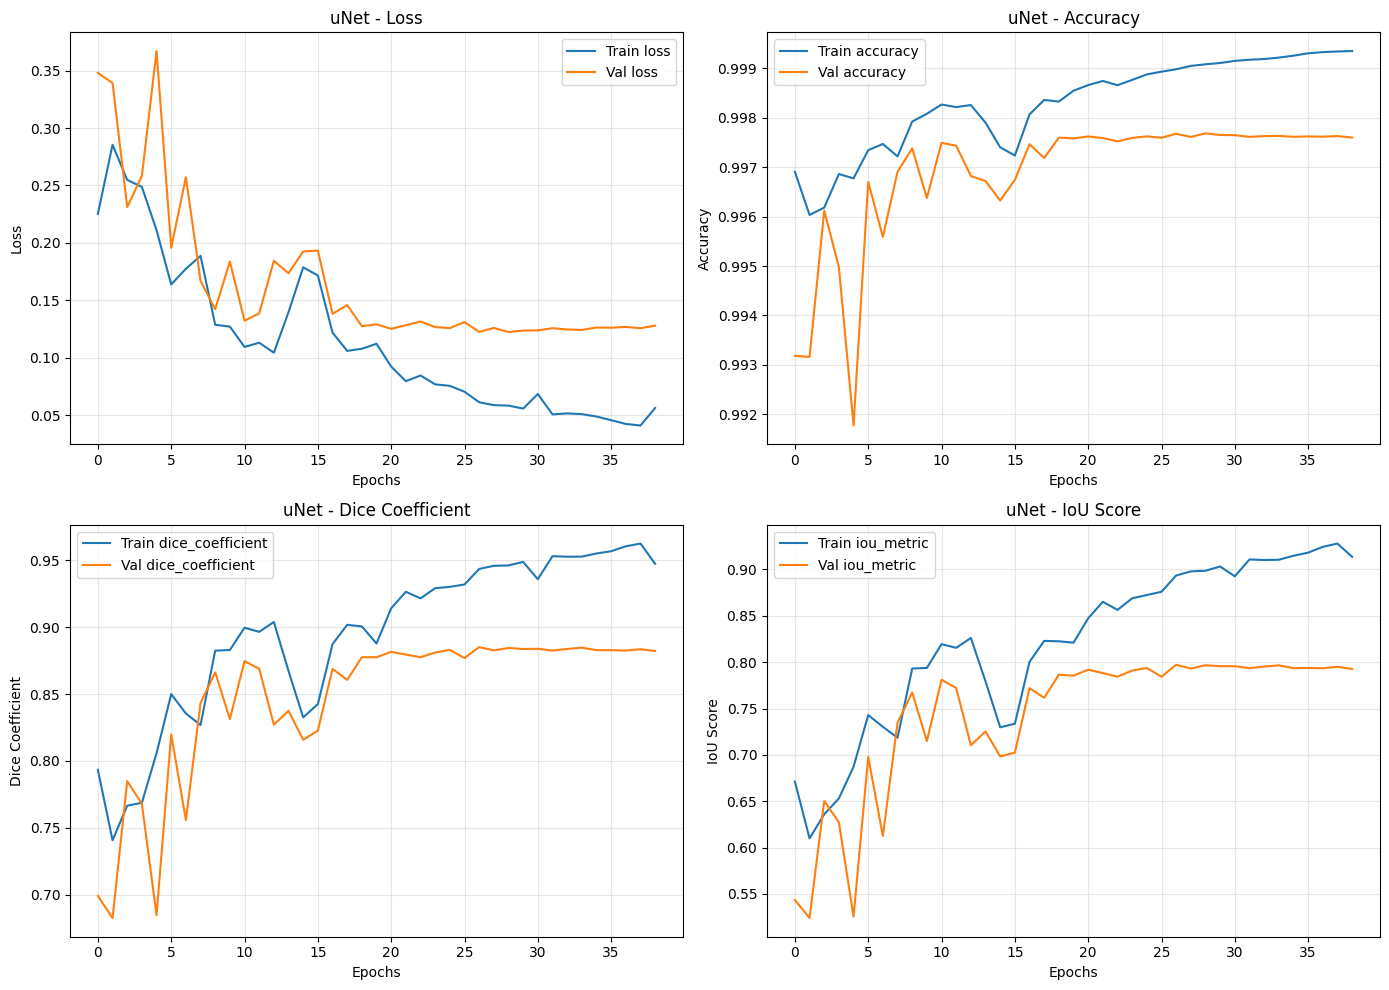

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x7a109587cf20>)

In [23]:
train_model(uNet, X_train, y_train, X_val, y_val, model_name='uNet', epochs=40, batch_size=16,learning_rate=3e-4)


Evaluating UNet...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step
Precision: 0.9080
Recall: 0.8598
F1-Score: 0.8833
IoU: 0.7910
Dice Coefficient: 0.8833
ROC AUC: 0.9933
PR AUC: 0.9330


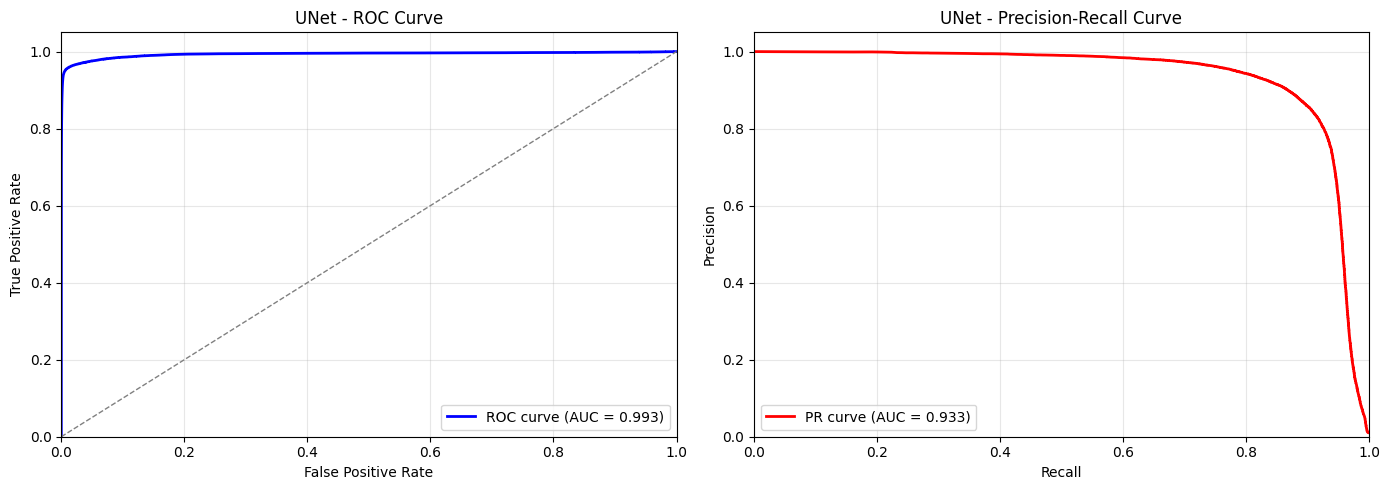

In [24]:

uNet_metrics = evaluate_model(uNet, X_test, y_test, model_name='UNet', plot_curves=True)


Training ResUnet...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8585 - dice_coefficient: 0.0425 - iou_metric: 0.0220 - loss: 1.3623
Epoch 1: val_dice_coefficient improved from -inf to 0.02361, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 794ms/step - accuracy: 0.8610 - dice_coefficient: 0.0436 - iou_metric: 0.0226 - loss: 1.3566 - val_accuracy: 0.9867 - val_dice_coefficient: 0.0236 - val_iou_metric: 0.0120 - val_loss: 1.5213 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9904 - dice_coefficient: 0.1867 - iou_metric: 0.1043 - loss: 0.8915
Epoch 2: val_dice_coefficient improved from 0.02361 to 0.02612, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.9905 - dice_coefficient: 0.1874 - iou_metric: 0.1048 - loss: 0.8906 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0261 - val_iou_metric: 0.0132 - val_loss: 1.3925 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9935 - dice_coefficient: 0.3070 - iou_metric: 0.1829 - loss: 0.7366
Epoch 3: val_dice_coefficient did not improve from 0.02612
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.9935 - dice_coefficient: 0.3082 - iou_metric: 0.1838 - loss: 0.7354 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0176 - val_iou_metric: 0.0089 - val_loss: 1.2946 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9955 - dice_coefficient: 0.4257 - iou_metric: 0.2729 - loss: 0.6036
Epoch 4: val_dice_coefficient did not improve from 0.02612
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.9955 - dice_coefficient: 0.4265 - iou_metric: 0.2736 - loss: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9977 - dice_coefficient: 0.7271 - iou_metric: 0.5750 - loss: 0.2848 - val_accuracy: 0.9897 - val_dice_coefficient: 0.0932 - val_iou_metric: 0.0498 - val_loss: 0.9645 - learning_rate: 1.0000e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9980 - dice_coefficient: 0.7527 - iou_metric: 0.6053 - loss: 0.2575
Epoch 12: val_dice_coefficient did not improve from 0.09324
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9980 - dice_coefficient: 0.7528 - iou_metric: 0.6054 - loss: 0.2573 - val_accuracy: 0.9894 - val_dice_coefficient: 0.0557 - val_iou_metric: 0.0295 - val_loss: 1.0056 - learning_rate: 1.0000e-04
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9978 - dice_coefficient: 0.7673 - iou_metric: 0.6255 - loss: 0.2435
Epoch 13: val_dice_coefficient improved from 0.09324 to 0.24942, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9978 - dice_coefficient: 0.7675 - iou_metric: 0.6257 - loss: 0.2433 - val_accuracy: 0.9910 - val_dice_coefficient: 0.2494 - val_iou_metric: 0.1451 - val_loss: 0.7989 - learning_rate: 1.0000e-04
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9981 - dice_coefficient: 0.7850 - iou_metric: 0.6480 - loss: 0.2247
Epoch 14: val_dice_coefficient improved from 0.24942 to 0.27102, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9981 - dice_coefficient: 0.7851 - iou_metric: 0.6482 - loss: 0.2246 - val_accuracy: 0.9911 - val_dice_coefficient: 0.2710 - val_iou_metric: 0.1599 - val_loss: 0.7775 - learning_rate: 1.0000e-04
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9981 - dice_coefficient: 0.7879 - iou_metric: 0.6527 - loss: 0.2217
Epoch 15: val_dice_coefficient improved from 0.27102 to 0.49303, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9981 - dice_coefficient: 0.7884 - iou_metric: 0.6533 - loss: 0.2212 - val_accuracy: 0.9932 - val_dice_coefficient: 0.4930 - val_iou_metric: 0.3309 - val_loss: 0.5393 - learning_rate: 1.0000e-04
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9983 - dice_coefficient: 0.8137 - iou_metric: 0.6889 - loss: 0.1947
Epoch 16: val_dice_coefficient improved from 0.49303 to 0.54702, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9983 - dice_coefficient: 0.8137 - iou_metric: 0.6890 - loss: 0.1946 - val_accuracy: 0.9938 - val_dice_coefficient: 0.5470 - val_iou_metric: 0.3788 - val_loss: 0.4832 - learning_rate: 1.0000e-04
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9982 - dice_coefficient: 0.8341 - iou_metric: 0.7168 - loss: 0.1744
Epoch 17: val_dice_coefficient improved from 0.54702 to 0.56008, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9982 - dice_coefficient: 0.8341 - iou_metric: 0.7167 - loss: 0.1746 - val_accuracy: 0.9939 - val_dice_coefficient: 0.5601 - val_iou_metric: 0.3951 - val_loss: 0.4698 - learning_rate: 1.0000e-04
Epoch 18/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9984 - dice_coefficient: 0.8322 - iou_metric: 0.7138 - loss: 0.1756
Epoch 18: val_dice_coefficient improved from 0.56008 to 0.62852, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9984 - dice_coefficient: 0.8325 - iou_metric: 0.7142 - loss: 0.1753 - val_accuracy: 0.9948 - val_dice_coefficient: 0.6285 - val_iou_metric: 0.4625 - val_loss: 0.3972 - learning_rate: 1.0000e-04
Epoch 19/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9984 - dice_coefficient: 0.8366 - iou_metric: 0.7218 - loss: 0.1711
Epoch 19: val_dice_coefficient improved from 0.62852 to 0.75596, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9984 - dice_coefficient: 0.8367 - iou_metric: 0.7220 - loss: 0.1710 - val_accuracy: 0.9963 - val_dice_coefficient: 0.7560 - val_iou_metric: 0.6095 - val_loss: 0.2611 - learning_rate: 1.0000e-04
Epoch 20/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9982 - dice_coefficient: 0.8394 - iou_metric: 0.7256 - loss: 0.1694
Epoch 20: val_dice_coefficient improved from 0.75596 to 0.77654, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9982 - dice_coefficient: 0.8397 - iou_metric: 0.7260 - loss: 0.1691 - val_accuracy: 0.9966 - val_dice_coefficient: 0.7765 - val_iou_metric: 0.6359 - val_loss: 0.2389 - learning_rate: 1.0000e-04
Epoch 21/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9983 - dice_coefficient: 0.8508 - iou_metric: 0.7424 - loss: 0.1574
Epoch 21: val_dice_coefficient improved from 0.77654 to 0.80686, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9983 - dice_coefficient: 0.8509 - iou_metric: 0.7426 - loss: 0.1573 - val_accuracy: 0.9969 - val_dice_coefficient: 0.8069 - val_iou_metric: 0.6774 - val_loss: 0.2077 - learning_rate: 1.0000e-04
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9985 - dice_coefficient: 0.8673 - iou_metric: 0.7666 - loss: 0.1401
Epoch 22: val_dice_coefficient improved from 0.80686 to 0.80706, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9985 - dice_coefficient: 0.8674 - iou_metric: 0.7668 - loss: 0.1400 - val_accuracy: 0.9971 - val_dice_coefficient: 0.8071 - val_iou_metric: 0.6781 - val_loss: 0.2053 - learning_rate: 1.0000e-04
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9986 - dice_coefficient: 0.8714 - iou_metric: 0.7739 - loss: 0.1340
Epoch 23: val_dice_coefficient improved from 0.80706 to 0.83468, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9987 - dice_coefficient: 0.8709 - iou_metric: 0.7736 - loss: 0.1339 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8347 - val_iou_metric: 0.7172 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 24/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9988 - dice_coefficient: 0.8795 - iou_metric: 0.7864 - loss: 0.1262
Epoch 24: val_dice_coefficient did not improve from 0.83468
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9988 - dice_coefficient: 0.8798 - iou_metric: 0.7869 - loss: 0.1259 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8293 - val_iou_metric: 0.7094 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 25/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9989 - dice_coefficient: 0.8978 - iou_metric: 0.8152 - loss: 0.1072
Epoch 25: val_dice_coefficient improved from 0.83468 to 0.84439, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9989 - dice_coefficient: 0.8978 - iou_metric: 0.8151 - loss: 0.1072 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8444 - val_iou_metric: 0.7316 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9989 - dice_coefficient: 0.8993 - iou_metric: 0.8182 - loss: 0.1058
Epoch 26: val_dice_coefficient did not improve from 0.84439
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9989 - dice_coefficient: 0.8992 - iou_metric: 0.8180 - loss: 0.1059 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8370 - val_iou_metric: 0.7207 - val_loss: 0.1744 - learning_rate: 1.0000e-04
Epoch 27/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9989 - dice_coefficient: 0.8972 - iou_metric: 0.8144 - loss: 0.1079
Epoch 27: val_dice_coefficient improved from 0.84439 to 0.84660, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9989 - dice_coefficient: 0.8973 - iou_metric: 0.8145 - loss: 0.1079 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8466 - val_iou_metric: 0.7351 - val_loss: 0.1640 - learning_rate: 1.0000e-04
Epoch 28/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9989 - dice_coefficient: 0.8957 - iou_metric: 0.8126 - loss: 0.1095
Epoch 28: val_dice_coefficient improved from 0.84660 to 0.84741, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9989 - dice_coefficient: 0.8960 - iou_metric: 0.8130 - loss: 0.1092 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8474 - val_iou_metric: 0.7367 - val_loss: 0.1630 - learning_rate: 1.0000e-04
Epoch 29/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9989 - dice_coefficient: 0.9165 - iou_metric: 0.8469 - loss: 0.0881
Epoch 29: val_dice_coefficient improved from 0.84741 to 0.85271, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9989 - dice_coefficient: 0.9163 - iou_metric: 0.8464 - loss: 0.0883 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8527 - val_iou_metric: 0.7444 - val_loss: 0.1572 - learning_rate: 1.0000e-04
Epoch 30/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9991 - dice_coefficient: 0.9177 - iou_metric: 0.8483 - loss: 0.0863
Epoch 30: val_dice_coefficient did not improve from 0.85271
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9991 - dice_coefficient: 0.9177 - iou_metric: 0.8483 - loss: 0.0863 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8515 - val_iou_metric: 0.7425 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 31/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9991 - dice_coefficient: 0.9168 - iou_metric: 0.8472 - loss: 0.0873
Epoch 31: val_dice_coefficient did not improve from 0.85271
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9991 - dice_coefficient: 0.9167 - iou_metric: 0.8472 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9990 - dice_coefficient: 0.9215 - iou_metric: 0.8550 - loss: 0.0827 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8586 - val_iou_metric: 0.7532 - val_loss: 0.1522 - learning_rate: 1.0000e-04
Epoch 33/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9991 - dice_coefficient: 0.9267 - iou_metric: 0.8637 - loss: 0.0772
Epoch 33: val_dice_coefficient improved from 0.85860 to 0.86482, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9991 - dice_coefficient: 0.9266 - iou_metric: 0.8636 - loss: 0.0773 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8648 - val_iou_metric: 0.7626 - val_loss: 0.1462 - learning_rate: 1.0000e-04
Epoch 34/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9992 - dice_coefficient: 0.9286 - iou_metric: 0.8673 - loss: 0.0751
Epoch 34: val_dice_coefficient did not improve from 0.86482
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9992 - dice_coefficient: 0.9286 - iou_metric: 0.8674 - loss: 0.0750 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8563 - val_iou_metric: 0.7496 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 35/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9993 - dice_coefficient: 0.9336 - iou_metric: 0.8759 - loss: 0.0697
Epoch 35: val_dice_coefficient did not improve from 0.86482
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9993 - dice_coefficient: 0.9336 - iou_metric: 0.8758 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9995 - dice_coefficient: 0.9512 - iou_metric: 0.9074 - loss: 0.0510 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8653 - val_iou_metric: 0.7636 - val_loss: 0.1468 - learning_rate: 5.0000e-05
Epoch 43/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9995 - dice_coefficient: 0.9561 - iou_metric: 0.9160 - loss: 0.0462
Epoch 43: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 43: val_dice_coefficient did not improve from 0.86534
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9995 - dice_coefficient: 0.9560 - iou_metric: 0.9159 - loss: 0.0462 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8626 - val_iou_metric: 0.7595 - val_loss: 0.1501 - learning_rate: 5.0000e-05
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.


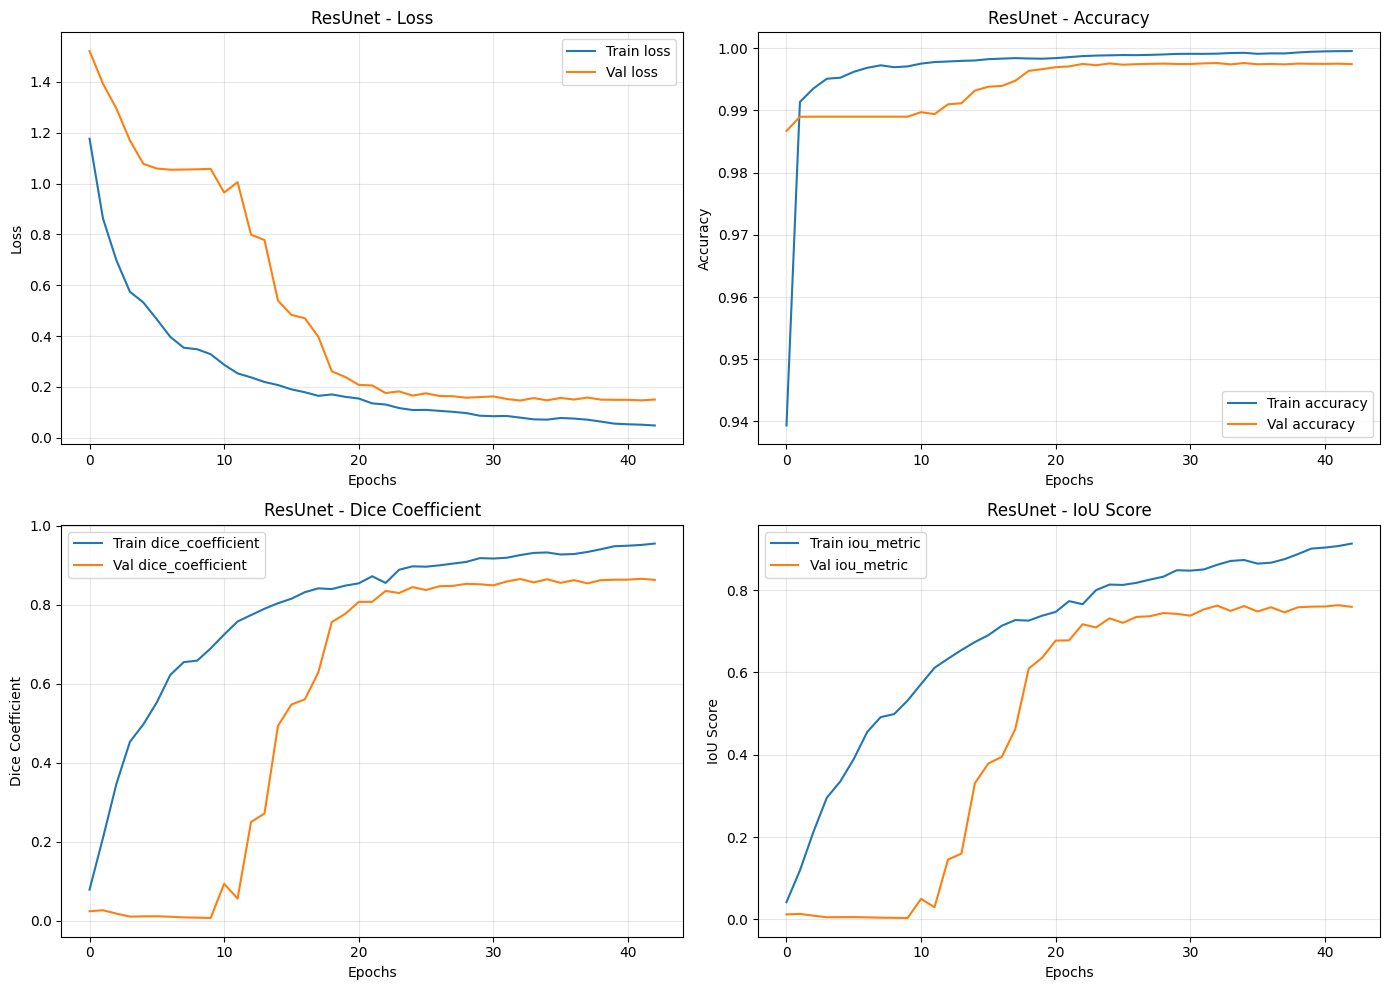

(<Functional name=functional_1, built=True>,
 <keras.src.callbacks.history.History at 0x7a0f9850f1d0>)

In [25]:
train_model(ResUnet, X_train, y_train, X_val, y_val, model_name='ResUnet', epochs=50, batch_size=32,learning_rate=1e-4)


Evaluating ResUNet...
----------------------------------------


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step
Precision: 0.9007
Recall: 0.8672
F1-Score: 0.8836
IoU: 0.7915
Dice Coefficient: 0.8836
ROC AUC: 0.9693
PR AUC: 0.9255


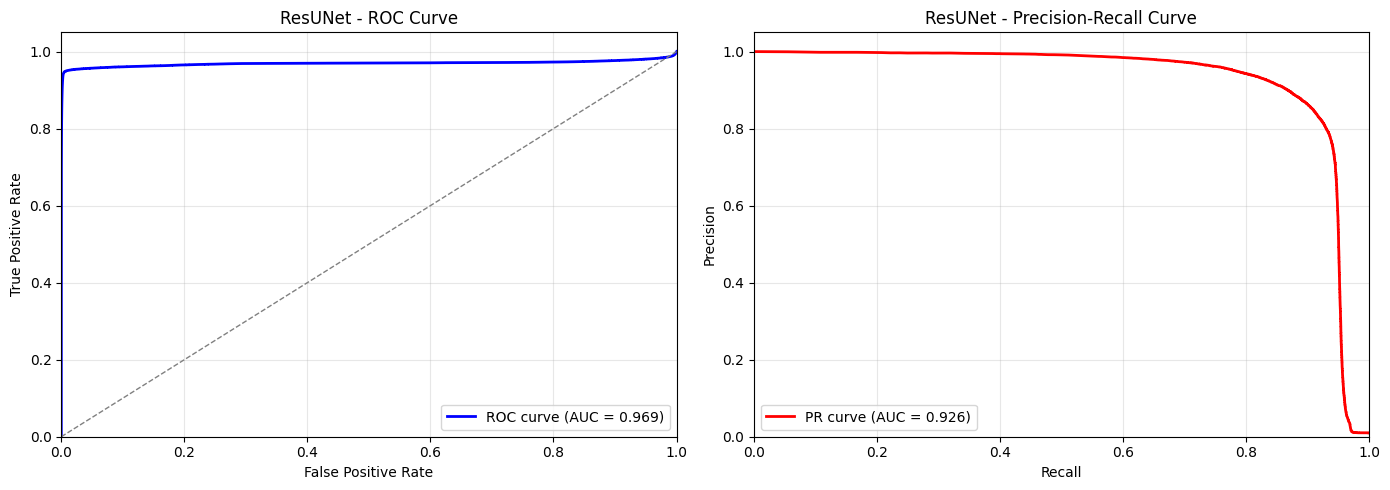

In [26]:
ResUnet_metrics = evaluate_model(ResUnet, X_test, y_test, model_name='ResUNet', plot_curves=True)


Training ResUnet...
----------------------------------------
Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9964 - dice_coefficient: 0.7980 - iou_metric: 0.6724 - loss: 0.2213
Epoch 1: val_dice_coefficient improved from -inf to 0.56077, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 379ms/step - accuracy: 0.9964 - dice_coefficient: 0.7975 - iou_metric: 0.6718 - loss: 0.2217 - val_accuracy: 0.9882 - val_dice_coefficient: 0.5608 - val_iou_metric: 0.3953 - val_loss: 0.4988 - learning_rate: 3.0000e-04
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9966 - dice_coefficient: 0.7910 - iou_metric: 0.6625 - loss: 0.2262
Epoch 2: val_dice_coefficient improved from 0.56077 to 0.80130, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9966 - dice_coefficient: 0.7911 - iou_metric: 0.6626 - loss: 0.2261 - val_accuracy: 0.9961 - val_dice_coefficient: 0.8013 - val_iou_metric: 0.6764 - val_loss: 0.2111 - learning_rate: 3.0000e-04
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9972 - dice_coefficient: 0.8010 - iou_metric: 0.6800 - loss: 0.2144
Epoch 3: val_dice_coefficient did not improve from 0.80130
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9972 - dice_coefficient: 0.8013 - iou_metric: 0.6804 - loss: 0.2140 - val_accuracy: 0.9943 - val_dice_coefficient: 0.7493 - val_iou_metric: 0.6034 - val_loss: 0.2668 - learning_rate: 3.0000e-04
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9976 - dice_coefficient: 0.8580 - iou_metric: 0.7567 - loss: 0.1535
Epoch 4: val_dice_coefficient improved from 0.80130 to 0.81171, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9976 - dice_coefficient: 0.8580 - iou_metric: 0.7566 - loss: 0.1536 - val_accuracy: 0.9961 - val_dice_coefficient: 0.8117 - val_iou_metric: 0.6903 - val_loss: 0.1984 - learning_rate: 3.0000e-04
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9976 - dice_coefficient: 0.8715 - iou_metric: 0.7757 - loss: 0.1404
Epoch 5: val_dice_coefficient did not improve from 0.81171
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9976 - dice_coefficient: 0.8713 - iou_metric: 0.7756 - loss: 0.1405 - val_accuracy: 0.9957 - val_dice_coefficient: 0.7955 - val_iou_metric: 0.6638 - val_loss: 0.2190 - learning_rate: 3.0000e-04
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9956 - dice_coefficient: 0.7629 - iou_metric: 0.6314 - loss: 0.2607
Epoch 6: val_dice_coefficient did not improve from 0.81171
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9956 - dice_coefficient: 0.7629 - iou_metric: 0.6314 - loss: 

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9963 - dice_coefficient: 0.7828 - iou_metric: 0.6587 - loss: 0.2376 - val_accuracy: 0.9965 - val_dice_coefficient: 0.8135 - val_iou_metric: 0.6910 - val_loss: 0.2004 - learning_rate: 3.0000e-04
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9979 - dice_coefficient: 0.8789 - iou_metric: 0.7863 - loss: 0.1315
Epoch 8: val_dice_coefficient improved from 0.81352 to 0.86264, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9979 - dice_coefficient: 0.8790 - iou_metric: 0.7863 - loss: 0.1315 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8626 - val_iou_metric: 0.7619 - val_loss: 0.1439 - learning_rate: 3.0000e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9982 - dice_coefficient: 0.8802 - iou_metric: 0.7905 - loss: 0.1287
Epoch 9: val_dice_coefficient did not improve from 0.86264
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9982 - dice_coefficient: 0.8803 - iou_metric: 0.7906 - loss: 0.1287 - val_accuracy: 0.9970 - val_dice_coefficient: 0.8490 - val_iou_metric: 0.7405 - val_loss: 0.1602 - learning_rate: 3.0000e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9983 - dice_coefficient: 0.8911 - iou_metric: 0.8064 - loss: 0.1170
Epoch 10: val_dice_coefficient improved from 0.86264 to 0.86746, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9983 - dice_coefficient: 0.8912 - iou_metric: 0.8066 - loss: 0.1169 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8675 - val_iou_metric: 0.7709 - val_loss: 0.1366 - learning_rate: 3.0000e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9986 - dice_coefficient: 0.8973 - iou_metric: 0.8186 - loss: 0.1095
Epoch 11: val_dice_coefficient did not improve from 0.86746
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9986 - dice_coefficient: 0.8975 - iou_metric: 0.8188 - loss: 0.1093 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8638 - val_iou_metric: 0.7650 - val_loss: 0.1416 - learning_rate: 3.0000e-04
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9982 - dice_coefficient: 0.9062 - iou_metric: 0.8319 - loss: 0.1019
Epoch 12: val_dice_coefficient improved from 0.86746 to 0.88084, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9982 - dice_coefficient: 0.9062 - iou_metric: 0.8319 - loss: 0.1019 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8808 - val_iou_metric: 0.7913 - val_loss: 0.1234 - learning_rate: 3.0000e-04
Epoch 13/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9985 - dice_coefficient: 0.9238 - iou_metric: 0.8602 - loss: 0.0832
Epoch 13: val_dice_coefficient did not improve from 0.88084
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9985 - dice_coefficient: 0.9238 - iou_metric: 0.8600 - loss: 0.0832 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8791 - val_iou_metric: 0.7888 - val_loss: 0.1252 - learning_rate: 3.0000e-04
Epoch 14/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9987 - dice_coefficient: 0.9126 - iou_metric: 0.8536 - loss: 0.0933
Epoch 14: val_dice_coefficient did not improve from 0.88084
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9987 - dice_coefficient: 0.9126 - iou_metric: 0.8536 - lo

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9990 - dice_coefficient: 0.9441 - iou_metric: 0.8962 - loss: 0.0608 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8863 - val_iou_metric: 0.7995 - val_loss: 0.1193 - learning_rate: 1.5000e-04
Epoch 20/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9991 - dice_coefficient: 0.9524 - iou_metric: 0.9094 - loss: 0.0520
Epoch 20: val_dice_coefficient improved from 0.88629 to 0.88634, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9991 - dice_coefficient: 0.9524 - iou_metric: 0.9094 - loss: 0.0520 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8863 - val_iou_metric: 0.7998 - val_loss: 0.1194 - learning_rate: 1.5000e-04
Epoch 21/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9993 - dice_coefficient: 0.9560 - iou_metric: 0.9159 - loss: 0.0475
Epoch 21: val_dice_coefficient improved from 0.88634 to 0.88636, saving model to best_ResUnet.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9993 - dice_coefficient: 0.9559 - iou_metric: 0.9158 - loss: 0.0475 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8864 - val_iou_metric: 0.8006 - val_loss: 0.1189 - learning_rate: 1.5000e-04
Epoch 22/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9992 - dice_coefficient: 0.9524 - iou_metric: 0.9099 - loss: 0.0519
Epoch 22: val_dice_coefficient did not improve from 0.88636
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9992 - dice_coefficient: 0.9524 - iou_metric: 0.9099 - loss: 0.0519 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8834 - val_iou_metric: 0.7952 - val_loss: 0.1233 - learning_rate: 1.5000e-04
Epoch 23/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9992 - dice_coefficient: 0.9452 - iou_metric: 0.8968 - loss: 0.0592
Epoch 23: val_dice_coefficient did not improve from 0.88636
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9992 - dice_coefficient: 0.9453 - iou_metric: 0.8970 - lo

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9994 - dice_coefficient: 0.9688 - iou_metric: 0.9397 - loss: 0.0342 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8864 - val_iou_metric: 0.7996 - val_loss: 0.1226 - learning_rate: 7.5000e-05
Epoch 31/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9994 - dice_coefficient: 0.9658 - iou_metric: 0.9341 - loss: 0.0378
Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 31: val_dice_coefficient did not improve from 0.88642
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9994 - dice_coefficient: 0.9657 - iou_metric: 0.9341 - loss: 0.0378 - val_accuracy: 0.9977 - val_dice_coefficient: 0.8836 - val_iou_metric: 0.7954 - val_loss: 0.1259 - learning_rate: 7.5000e-05
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.


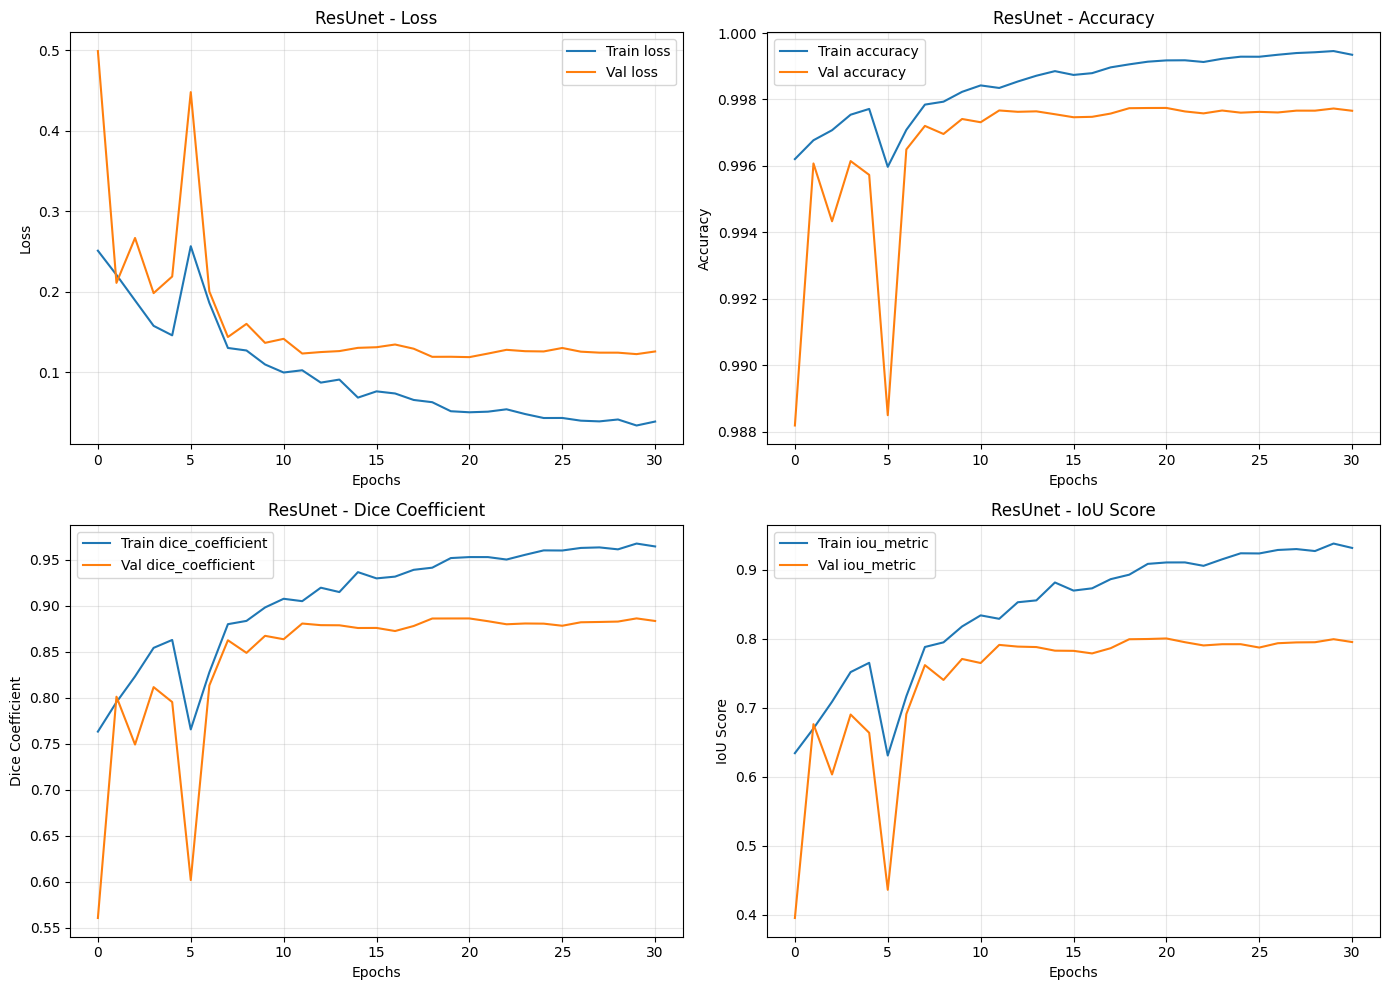

(<Functional name=functional_1, built=True>,
 <keras.src.callbacks.history.History at 0x7a0f80e19970>)

In [27]:
train_model(ResUnet, X_train, y_train, X_val, y_val, model_name='ResUnet', epochs=40, batch_size=16,learning_rate=3e-4)


Evaluating ResUNet...
----------------------------------------


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step
Precision: 0.9122
Recall: 0.8688
F1-Score: 0.8900
IoU: 0.8018
Dice Coefficient: 0.8900
ROC AUC: 0.9905
PR AUC: 0.9367


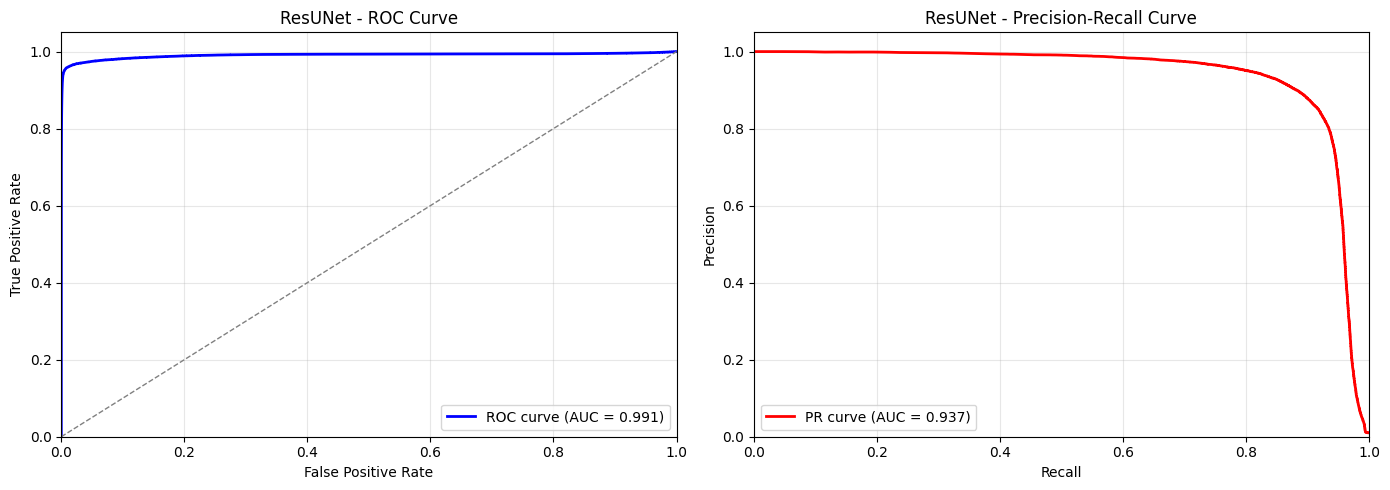

In [28]:
ResUnet_metrics = evaluate_model(ResUnet, X_test, y_test, model_name='ResUNet', plot_curves=True)


Training DeepLab...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6288 - dice_coefficient: 0.0304 - iou_metric: 0.0155 - loss: 1.6565
Epoch 1: val_dice_coefficient improved from -inf to 0.02256, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6330 - dice_coefficient: 0.0306 - iou_metric: 0.0156 - loss: 1.6524 - val_accuracy: 0.9813 - val_dice_coefficient: 0.0226 - val_iou_metric: 0.0114 - val_loss: 1.5692 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9672 - dice_coefficient: 0.0534 - iou_metric: 0.0275 - loss: 1.2584
Epoch 2: val_dice_coefficient improved from 0.02256 to 0.02520, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.9674 - dice_coefficient: 0.0536 - iou_metric: 0.0276 - loss: 1.2575 - val_accuracy: 0.8934 - val_dice_coefficient: 0.0252 - val_iou_metric: 0.0128 - val_loss: 1.5190 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9866 - dice_coefficient: 0.0728 - iou_metric: 0.0380 - loss: 1.1529
Epoch 3: val_dice_coefficient improved from 0.02520 to 0.02531, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9867 - dice_coefficient: 0.0728 - iou_metric: 0.0380 - loss: 1.1526 - val_accuracy: 0.9647 - val_dice_coefficient: 0.0253 - val_iou_metric: 0.0128 - val_loss: 1.5191 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9880 - dice_coefficient: 0.0795 - iou_metric: 0.0417 - loss: 1.1111
Epoch 4: val_dice_coefficient did not improve from 0.02531
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9880 - dice_coefficient: 0.0797 - iou_metric: 0.0417 - loss: 1.1107 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0204 - val_iou_metric: 0.0103 - val_loss: 1.4657 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9900 - dice_coefficient: 0.0937 - iou_metric: 0.0496 - loss: 1.0700
Epoch 5: val_dice_coefficient did not improve from 0.02531
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9900 - dice_coefficient: 0.0938 - iou_metric: 0.0496 - los

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9919 - dice_coefficient: 0.1186 - iou_metric: 0.0633 - loss: 1.0116 - val_accuracy: 0.9893 - val_dice_coefficient: 0.0272 - val_iou_metric: 0.0138 - val_loss: 1.2013 - learning_rate: 1.0000e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9918 - dice_coefficient: 0.1314 - iou_metric: 0.0707 - loss: 0.9930
Epoch 8: val_dice_coefficient improved from 0.02724 to 0.03089, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9918 - dice_coefficient: 0.1314 - iou_metric: 0.0707 - loss: 0.9929 - val_accuracy: 0.9895 - val_dice_coefficient: 0.0309 - val_iou_metric: 0.0157 - val_loss: 1.1465 - learning_rate: 1.0000e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9924 - dice_coefficient: 0.1408 - iou_metric: 0.0762 - loss: 0.9688
Epoch 9: val_dice_coefficient improved from 0.03089 to 0.04744, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9924 - dice_coefficient: 0.1411 - iou_metric: 0.0763 - loss: 0.9684 - val_accuracy: 0.9914 - val_dice_coefficient: 0.0474 - val_iou_metric: 0.0243 - val_loss: 1.1277 - learning_rate: 1.0000e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9926 - dice_coefficient: 0.1669 - iou_metric: 0.0916 - loss: 0.9337
Epoch 10: val_dice_coefficient improved from 0.04744 to 0.06810, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9926 - dice_coefficient: 0.1665 - iou_metric: 0.0915 - loss: 0.9340 - val_accuracy: 0.9922 - val_dice_coefficient: 0.0681 - val_iou_metric: 0.0353 - val_loss: 1.0682 - learning_rate: 1.0000e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9923 - dice_coefficient: 0.1851 - iou_metric: 0.1024 - loss: 0.9065
Epoch 11: val_dice_coefficient improved from 0.06810 to 0.07279, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9923 - dice_coefficient: 0.1847 - iou_metric: 0.1022 - loss: 0.9069 - val_accuracy: 0.9922 - val_dice_coefficient: 0.0728 - val_iou_metric: 0.0379 - val_loss: 1.0556 - learning_rate: 1.0000e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9936 - dice_coefficient: 0.1803 - iou_metric: 0.1000 - loss: 0.9052
Epoch 12: val_dice_coefficient improved from 0.07279 to 0.10326, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9936 - dice_coefficient: 0.1805 - iou_metric: 0.1001 - loss: 0.9051 - val_accuracy: 0.9932 - val_dice_coefficient: 0.1033 - val_iou_metric: 0.0546 - val_loss: 1.0082 - learning_rate: 1.0000e-04
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9938 - dice_coefficient: 0.2075 - iou_metric: 0.1168 - loss: 0.8703
Epoch 13: val_dice_coefficient improved from 0.10326 to 0.12853, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9938 - dice_coefficient: 0.2074 - iou_metric: 0.1167 - loss: 0.8704 - val_accuracy: 0.9919 - val_dice_coefficient: 0.1285 - val_iou_metric: 0.0689 - val_loss: 0.9738 - learning_rate: 1.0000e-04
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9939 - dice_coefficient: 0.2168 - iou_metric: 0.1228 - loss: 0.8547
Epoch 14: val_dice_coefficient improved from 0.12853 to 0.15789, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9939 - dice_coefficient: 0.2169 - iou_metric: 0.1229 - loss: 0.8546 - val_accuracy: 0.9941 - val_dice_coefficient: 0.1579 - val_iou_metric: 0.0860 - val_loss: 0.9255 - learning_rate: 1.0000e-04
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9946 - dice_coefficient: 0.2304 - iou_metric: 0.1316 - loss: 0.8346
Epoch 15: val_dice_coefficient improved from 0.15789 to 0.18455, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9946 - dice_coefficient: 0.2307 - iou_metric: 0.1318 - loss: 0.8344 - val_accuracy: 0.9943 - val_dice_coefficient: 0.1846 - val_iou_metric: 0.1021 - val_loss: 0.8939 - learning_rate: 1.0000e-04
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9943 - dice_coefficient: 0.2348 - iou_metric: 0.1350 - loss: 0.8289
Epoch 16: val_dice_coefficient improved from 0.18455 to 0.19453, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9943 - dice_coefficient: 0.2349 - iou_metric: 0.1350 - loss: 0.8288 - val_accuracy: 0.9942 - val_dice_coefficient: 0.1945 - val_iou_metric: 0.1082 - val_loss: 0.8718 - learning_rate: 1.0000e-04
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9955 - dice_coefficient: 0.2360 - iou_metric: 0.1353 - loss: 0.8201
Epoch 17: val_dice_coefficient improved from 0.19453 to 0.24650, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9955 - dice_coefficient: 0.2369 - iou_metric: 0.1359 - loss: 0.8192 - val_accuracy: 0.9932 - val_dice_coefficient: 0.2465 - val_iou_metric: 0.1413 - val_loss: 0.8188 - learning_rate: 1.0000e-04
Epoch 18/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9941 - dice_coefficient: 0.2921 - iou_metric: 0.1731 - loss: 0.7627
Epoch 18: val_dice_coefficient did not improve from 0.24650
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.9941 - dice_coefficient: 0.2917 - iou_metric: 0.1728 - loss: 0.7630 - val_accuracy: 0.9849 - val_dice_coefficient: 0.2274 - val_iou_metric: 0.1288 - val_loss: 0.8589 - learning_rate: 1.0000e-04
Epoch 19/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9937 - dice_coefficient: 0.2862 - iou_metric: 0.1688 - loss: 0.7666
Epoch 19: val_dice_coefficient improved from 0.24650 to 0.26364, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9937 - dice_coefficient: 0.2865 - iou_metric: 0.1690 - loss: 0.7661 - val_accuracy: 0.9908 - val_dice_coefficient: 0.2636 - val_iou_metric: 0.1525 - val_loss: 0.8027 - learning_rate: 1.0000e-04
Epoch 20/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9957 - dice_coefficient: 0.3117 - iou_metric: 0.1870 - loss: 0.7333
Epoch 20: val_dice_coefficient improved from 0.26364 to 0.28970, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9957 - dice_coefficient: 0.3122 - iou_metric: 0.1874 - loss: 0.7329 - val_accuracy: 0.9945 - val_dice_coefficient: 0.2897 - val_iou_metric: 0.1702 - val_loss: 0.7649 - learning_rate: 1.0000e-04
Epoch 21/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9958 - dice_coefficient: 0.3382 - iou_metric: 0.2058 - loss: 0.7032
Epoch 21: val_dice_coefficient did not improve from 0.28970
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.9958 - dice_coefficient: 0.3385 - iou_metric: 0.2060 - loss: 0.7030 - val_accuracy: 0.9902 - val_dice_coefficient: 0.2865 - val_iou_metric: 0.1680 - val_loss: 0.7790 - learning_rate: 1.0000e-04
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9954 - dice_coefficient: 0.3830 - iou_metric: 0.2390 - loss: 0.6572
Epoch 22: val_dice_coefficient improved from 0.28970 to 0.34320, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9954 - dice_coefficient: 0.3825 - iou_metric: 0.2387 - loss: 0.6578 - val_accuracy: 0.9963 - val_dice_coefficient: 0.3432 - val_iou_metric: 0.2082 - val_loss: 0.6958 - learning_rate: 1.0000e-04
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9961 - dice_coefficient: 0.4037 - iou_metric: 0.2545 - loss: 0.6318
Epoch 23: val_dice_coefficient improved from 0.34320 to 0.34926, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9961 - dice_coefficient: 0.4033 - iou_metric: 0.2542 - loss: 0.6323 - val_accuracy: 0.9930 - val_dice_coefficient: 0.3493 - val_iou_metric: 0.2126 - val_loss: 0.6995 - learning_rate: 1.0000e-04
Epoch 24/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9968 - dice_coefficient: 0.3829 - iou_metric: 0.2415 - loss: 0.6487
Epoch 24: val_dice_coefficient improved from 0.34926 to 0.36887, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9968 - dice_coefficient: 0.3836 - iou_metric: 0.2420 - loss: 0.6480 - val_accuracy: 0.9945 - val_dice_coefficient: 0.3689 - val_iou_metric: 0.2272 - val_loss: 0.6750 - learning_rate: 1.0000e-04
Epoch 25/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9966 - dice_coefficient: 0.4049 - iou_metric: 0.2574 - loss: 0.6255
Epoch 25: val_dice_coefficient improved from 0.36887 to 0.43125, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9966 - dice_coefficient: 0.4055 - iou_metric: 0.2580 - loss: 0.6250 - val_accuracy: 0.9962 - val_dice_coefficient: 0.4313 - val_iou_metric: 0.2761 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9969 - dice_coefficient: 0.4343 - iou_metric: 0.2814 - loss: 0.5936
Epoch 26: val_dice_coefficient improved from 0.43125 to 0.45078, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9969 - dice_coefficient: 0.4345 - iou_metric: 0.2816 - loss: 0.5933 - val_accuracy: 0.9957 - val_dice_coefficient: 0.4508 - val_iou_metric: 0.2924 - val_loss: 0.5815 - learning_rate: 1.0000e-04
Epoch 27/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9964 - dice_coefficient: 0.4807 - iou_metric: 0.3241 - loss: 0.5474
Epoch 27: val_dice_coefficient improved from 0.45078 to 0.46227, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9964 - dice_coefficient: 0.4801 - iou_metric: 0.3235 - loss: 0.5479 - val_accuracy: 0.9965 - val_dice_coefficient: 0.4623 - val_iou_metric: 0.3020 - val_loss: 0.5654 - learning_rate: 1.0000e-04
Epoch 28/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9967 - dice_coefficient: 0.4727 - iou_metric: 0.3142 - loss: 0.5524
Epoch 28: val_dice_coefficient improved from 0.46227 to 0.47975, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9967 - dice_coefficient: 0.4730 - iou_metric: 0.3145 - loss: 0.5521 - val_accuracy: 0.9943 - val_dice_coefficient: 0.4797 - val_iou_metric: 0.3170 - val_loss: 0.5555 - learning_rate: 1.0000e-04
Epoch 29/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9969 - dice_coefficient: 0.5396 - iou_metric: 0.3717 - loss: 0.4834
Epoch 29: val_dice_coefficient improved from 0.47975 to 0.50262, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9969 - dice_coefficient: 0.5389 - iou_metric: 0.3712 - loss: 0.4840 - val_accuracy: 0.9948 - val_dice_coefficient: 0.5026 - val_iou_metric: 0.3370 - val_loss: 0.5283 - learning_rate: 1.0000e-04
Epoch 30/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9969 - dice_coefficient: 0.5096 - iou_metric: 0.3489 - loss: 0.5127
Epoch 30: val_dice_coefficient improved from 0.50262 to 0.51035, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9969 - dice_coefficient: 0.5104 - iou_metric: 0.3496 - loss: 0.5120 - val_accuracy: 0.9942 - val_dice_coefficient: 0.5104 - val_iou_metric: 0.3441 - val_loss: 0.5195 - learning_rate: 1.0000e-04
Epoch 31/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9968 - dice_coefficient: 0.5692 - iou_metric: 0.3999 - loss: 0.4520
Epoch 31: val_dice_coefficient improved from 0.51035 to 0.55333, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9968 - dice_coefficient: 0.5692 - iou_metric: 0.3999 - loss: 0.4520 - val_accuracy: 0.9957 - val_dice_coefficient: 0.5533 - val_iou_metric: 0.3837 - val_loss: 0.4715 - learning_rate: 1.0000e-04
Epoch 32/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9974 - dice_coefficient: 0.5642 - iou_metric: 0.3982 - loss: 0.4543
Epoch 32: val_dice_coefficient improved from 0.55333 to 0.56325, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9974 - dice_coefficient: 0.5647 - iou_metric: 0.3988 - loss: 0.4539 - val_accuracy: 0.9955 - val_dice_coefficient: 0.5633 - val_iou_metric: 0.3935 - val_loss: 0.4631 - learning_rate: 1.0000e-04
Epoch 33/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9973 - dice_coefficient: 0.5815 - iou_metric: 0.4161 - loss: 0.4363
Epoch 33: val_dice_coefficient improved from 0.56325 to 0.58393, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9973 - dice_coefficient: 0.5819 - iou_metric: 0.4165 - loss: 0.4359 - val_accuracy: 0.9951 - val_dice_coefficient: 0.5839 - val_iou_metric: 0.4135 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 34/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9966 - dice_coefficient: 0.6045 - iou_metric: 0.4377 - loss: 0.4156
Epoch 34: val_dice_coefficient improved from 0.58393 to 0.61296, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9966 - dice_coefficient: 0.6044 - iou_metric: 0.4378 - loss: 0.4153 - val_accuracy: 0.9957 - val_dice_coefficient: 0.6130 - val_iou_metric: 0.4431 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 35/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9974 - dice_coefficient: 0.6308 - iou_metric: 0.4652 - loss: 0.3851
Epoch 35: val_dice_coefficient improved from 0.61296 to 0.61901, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9974 - dice_coefficient: 0.6307 - iou_metric: 0.4652 - loss: 0.3850 - val_accuracy: 0.9955 - val_dice_coefficient: 0.6190 - val_iou_metric: 0.4499 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 36/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9975 - dice_coefficient: 0.6572 - iou_metric: 0.4925 - loss: 0.3577
Epoch 36: val_dice_coefficient improved from 0.61901 to 0.62721, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9975 - dice_coefficient: 0.6569 - iou_metric: 0.4922 - loss: 0.3579 - val_accuracy: 0.9966 - val_dice_coefficient: 0.6272 - val_iou_metric: 0.4585 - val_loss: 0.3893 - learning_rate: 1.0000e-04
Epoch 37/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9976 - dice_coefficient: 0.6700 - iou_metric: 0.5071 - loss: 0.3441
Epoch 37: val_dice_coefficient improved from 0.62721 to 0.66357, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9976 - dice_coefficient: 0.6700 - iou_metric: 0.5071 - loss: 0.3442 - val_accuracy: 0.9965 - val_dice_coefficient: 0.6636 - val_iou_metric: 0.4984 - val_loss: 0.3553 - learning_rate: 1.0000e-04
Epoch 38/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9976 - dice_coefficient: 0.6682 - iou_metric: 0.5064 - loss: 0.3456
Epoch 38: val_dice_coefficient improved from 0.66357 to 0.66620, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9976 - dice_coefficient: 0.6687 - iou_metric: 0.5069 - loss: 0.3452 - val_accuracy: 0.9966 - val_dice_coefficient: 0.6662 - val_iou_metric: 0.5008 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 39/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9977 - dice_coefficient: 0.6911 - iou_metric: 0.5353 - loss: 0.3214
Epoch 39: val_dice_coefficient improved from 0.66620 to 0.68892, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9977 - dice_coefficient: 0.6910 - iou_metric: 0.5352 - loss: 0.3213 - val_accuracy: 0.9970 - val_dice_coefficient: 0.6889 - val_iou_metric: 0.5266 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 40/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9977 - dice_coefficient: 0.6907 - iou_metric: 0.5335 - loss: 0.3216
Epoch 40: val_dice_coefficient improved from 0.68892 to 0.69905, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9977 - dice_coefficient: 0.6911 - iou_metric: 0.5338 - loss: 0.3212 - val_accuracy: 0.9971 - val_dice_coefficient: 0.6991 - val_iou_metric: 0.5386 - val_loss: 0.3155 - learning_rate: 1.0000e-04
Epoch 41/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9975 - dice_coefficient: 0.7090 - iou_metric: 0.5528 - loss: 0.3046
Epoch 41: val_dice_coefficient improved from 0.69905 to 0.70754, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9975 - dice_coefficient: 0.7091 - iou_metric: 0.5528 - loss: 0.3045 - val_accuracy: 0.9970 - val_dice_coefficient: 0.7075 - val_iou_metric: 0.5483 - val_loss: 0.3063 - learning_rate: 1.0000e-04
Epoch 42/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9975 - dice_coefficient: 0.7284 - iou_metric: 0.5767 - loss: 0.2844
Epoch 42: val_dice_coefficient improved from 0.70754 to 0.72649, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9975 - dice_coefficient: 0.7281 - iou_metric: 0.5765 - loss: 0.2846 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7265 - val_iou_metric: 0.5714 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 43/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9978 - dice_coefficient: 0.7504 - iou_metric: 0.6032 - loss: 0.2611
Epoch 43: val_dice_coefficient did not improve from 0.72649
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9978 - dice_coefficient: 0.7503 - iou_metric: 0.6030 - loss: 0.2612 - val_accuracy: 0.9961 - val_dice_coefficient: 0.7068 - val_iou_metric: 0.5480 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 44/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9978 - dice_coefficient: 0.7636 - iou_metric: 0.6215 - loss: 0.2476
Epoch 44: val_dice_coefficient improved from 0.72649 to 0.74518, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9978 - dice_coefficient: 0.7630 - iou_metric: 0.6208 - loss: 0.2482 - val_accuracy: 0.9970 - val_dice_coefficient: 0.7452 - val_iou_metric: 0.5948 - val_loss: 0.2687 - learning_rate: 1.0000e-04
Epoch 45/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9979 - dice_coefficient: 0.7616 - iou_metric: 0.6188 - loss: 0.2490
Epoch 45: val_dice_coefficient did not improve from 0.74518
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9979 - dice_coefficient: 0.7615 - iou_metric: 0.6187 - loss: 0.2492 - val_accuracy: 0.9967 - val_dice_coefficient: 0.7401 - val_iou_metric: 0.5883 - val_loss: 0.2757 - learning_rate: 1.0000e-04
Epoch 46/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9978 - dice_coefficient: 0.7644 - iou_metric: 0.6209 - loss: 0.2471
Epoch 46: val_dice_coefficient improved from 0.74518 to 0.76392, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9978 - dice_coefficient: 0.7647 - iou_metric: 0.6214 - loss: 0.2468 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7639 - val_iou_metric: 0.6188 - val_loss: 0.2482 - learning_rate: 1.0000e-04
Epoch 47/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9980 - dice_coefficient: 0.7769 - iou_metric: 0.6385 - loss: 0.2334
Epoch 47: val_dice_coefficient did not improve from 0.76392
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9980 - dice_coefficient: 0.7770 - iou_metric: 0.6386 - loss: 0.2332 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7625 - val_iou_metric: 0.6170 - val_loss: 0.2500 - learning_rate: 1.0000e-04
Epoch 48/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9978 - dice_coefficient: 0.7716 - iou_metric: 0.6317 - loss: 0.2390
Epoch 48: val_dice_coefficient improved from 0.76392 to 0.77408, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.9978 - dice_coefficient: 0.7716 - iou_metric: 0.6317 - loss: 0.2391 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7741 - val_iou_metric: 0.6323 - val_loss: 0.2385 - learning_rate: 1.0000e-04
Epoch 49/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9980 - dice_coefficient: 0.7890 - iou_metric: 0.6558 - loss: 0.2210
Epoch 49: val_dice_coefficient improved from 0.77408 to 0.77909, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9980 - dice_coefficient: 0.7889 - iou_metric: 0.6557 - loss: 0.2209 - val_accuracy: 0.9969 - val_dice_coefficient: 0.7791 - val_iou_metric: 0.6389 - val_loss: 0.2341 - learning_rate: 1.0000e-04
Epoch 50/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9978 - dice_coefficient: 0.7914 - iou_metric: 0.6599 - loss: 0.2191
Epoch 50: val_dice_coefficient improved from 0.77909 to 0.79411, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9978 - dice_coefficient: 0.7916 - iou_metric: 0.6601 - loss: 0.2189 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7941 - val_iou_metric: 0.6593 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.


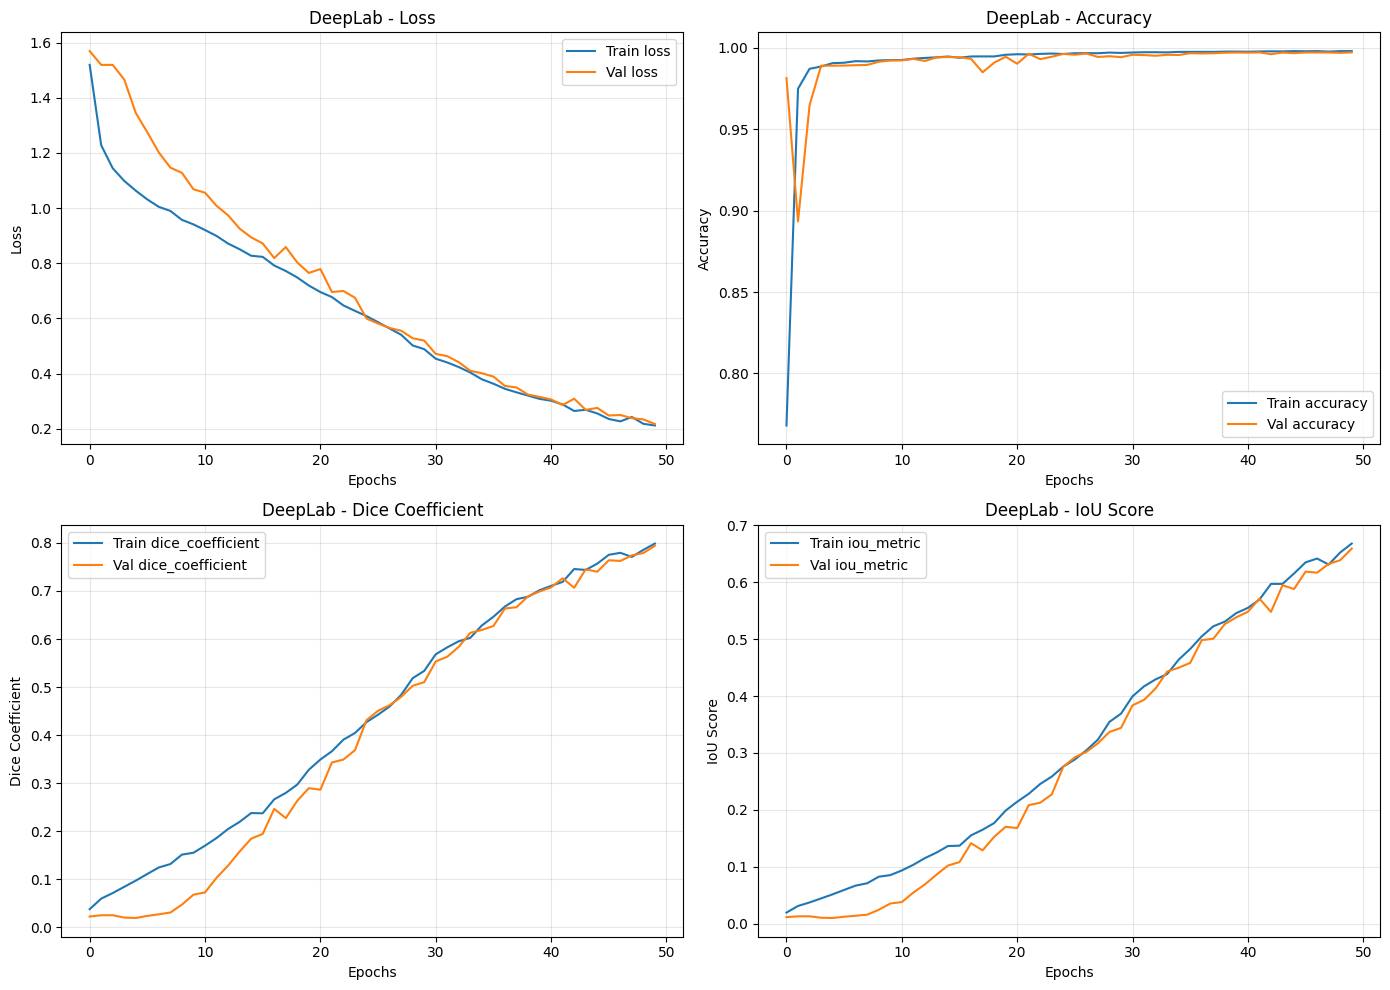

(<Functional name=functional_2, built=True>,
 <keras.src.callbacks.history.History at 0x7a0f3c734ec0>)

In [29]:
train_model(DeepLab, X_train, y_train, X_val, y_val, model_name='DeepLab', epochs=50, batch_size=32,learning_rate=1e-4)


Evaluating DeepLab...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step
Precision: 0.8738
Recall: 0.8464
F1-Score: 0.8599
IoU: 0.7542
Dice Coefficient: 0.8599
ROC AUC: 0.9908
PR AUC: 0.9099


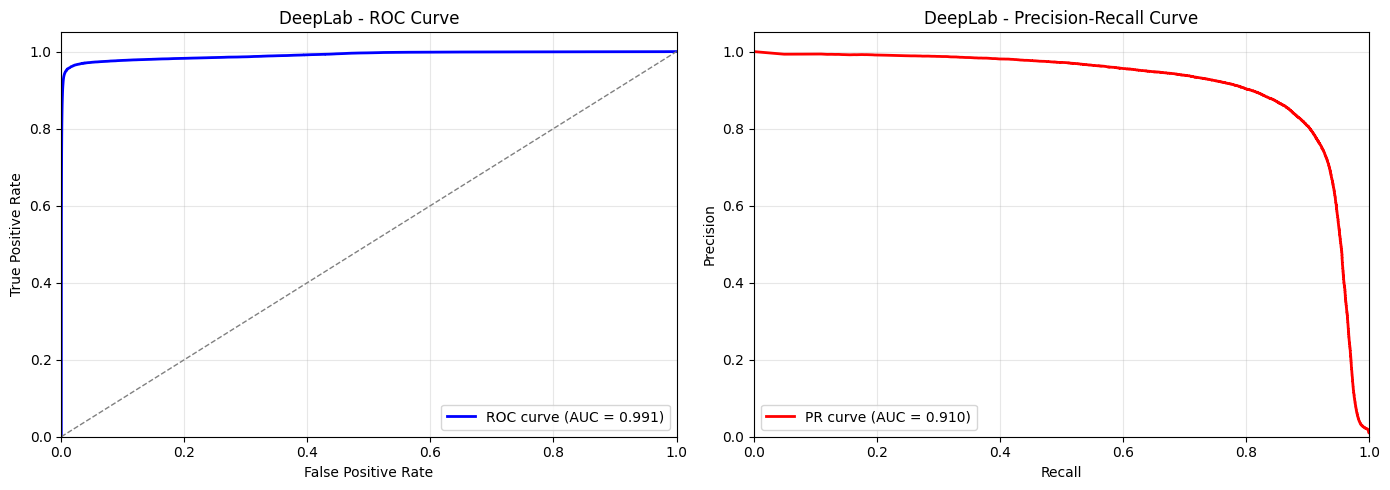

{'model_name': 'DeepLab',
 'precision': 0.8737827607131505,
 'recall': 0.8463906849161699,
 'f1_score': 0.8598686268376603,
 'iou': np.float64(0.7541838134430727),
 'dice': 0.8598686456680298,
 'roc_auc': np.float64(0.9907722610306176),
 'pr_auc': np.float64(0.909929117905427),
 'y_pred': array([[[[0.0017759 ],
          [0.00182799],
          [0.00169814],
          ...,
          [0.00158788],
          [0.00173725],
          [0.00182003]],
 
         [[0.00189447],
          [0.0016161 ],
          [0.00162452],
          ...,
          [0.00152608],
          [0.00156685],
          [0.00168532]],
 
         [[0.00173365],
          [0.00155691],
          [0.001625  ],
          ...,
          [0.00154   ],
          [0.0014917 ],
          [0.00156941]],
 
         ...,
 
         [[0.00166019],
          [0.0015492 ],
          [0.00157851],
          ...,
          [0.0016549 ],
          [0.00161759],
          [0.00168436]],
 
         [[0.00194839],
          [0.00166801],

In [30]:
evaluate_model(DeepLab, X_test, y_test, model_name='DeepLab', plot_curves=True)


Training DeepLab...
----------------------------------------
Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9956 - dice_coefficient: 0.7121 - iou_metric: 0.5604 - loss: 0.3088
Epoch 1: val_dice_coefficient improved from -inf to 0.71087, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 347ms/step - accuracy: 0.9956 - dice_coefficient: 0.7125 - iou_metric: 0.5609 - loss: 0.3083 - val_accuracy: 0.9940 - val_dice_coefficient: 0.7109 - val_iou_metric: 0.5565 - val_loss: 0.3090 - learning_rate: 3.0000e-04
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9964 - dice_coefficient: 0.7364 - iou_metric: 0.5973 - loss: 0.2802
Epoch 2: val_dice_coefficient did not improve from 0.71087
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9964 - dice_coefficient: 0.7365 - iou_metric: 0.5975 - loss: 0.2800 - val_accuracy: 0.9939 - val_dice_coefficient: 0.5532 - val_iou_metric: 0.3879 - val_loss: 0.4792 - learning_rate: 3.0000e-04
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9964 - dice_coefficient: 0.7350 - iou_metric: 0.5912 - loss: 0.2820
Epoch 3: val_dice_coefficient improved from 0.71087 to 0.80342, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9964 - dice_coefficient: 0.7354 - iou_metric: 0.5918 - loss: 0.2815 - val_accuracy: 0.9963 - val_dice_coefficient: 0.8034 - val_iou_metric: 0.6741 - val_loss: 0.2065 - learning_rate: 3.0000e-04
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9969 - dice_coefficient: 0.7693 - iou_metric: 0.6399 - loss: 0.2447
Epoch 4: val_dice_coefficient improved from 0.80342 to 0.83159, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9969 - dice_coefficient: 0.7697 - iou_metric: 0.6404 - loss: 0.2444 - val_accuracy: 0.9970 - val_dice_coefficient: 0.8316 - val_iou_metric: 0.7153 - val_loss: 0.1746 - learning_rate: 3.0000e-04
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9973 - dice_coefficient: 0.7904 - iou_metric: 0.6630 - loss: 0.2227
Epoch 5: val_dice_coefficient did not improve from 0.83159
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9973 - dice_coefficient: 0.7907 - iou_metric: 0.6634 - loss: 0.2224 - val_accuracy: 0.9939 - val_dice_coefficient: 0.7366 - val_iou_metric: 0.5922 - val_loss: 0.2875 - learning_rate: 3.0000e-04
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9973 - dice_coefficient: 0.8360 - iou_metric: 0.7220 - loss: 0.1767
Epoch 6: val_dice_coefficient did not improve from 0.83159
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9973 - dice_coefficient: 0.8359 - iou_metric: 0.7219 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9973 - dice_coefficient: 0.8322 - iou_metric: 0.7194 - loss: 0.1805 - val_accuracy: 0.9967 - val_dice_coefficient: 0.8337 - val_iou_metric: 0.7187 - val_loss: 0.1758 - learning_rate: 3.0000e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9975 - dice_coefficient: 0.8225 - iou_metric: 0.7149 - loss: 0.1898
Epoch 9: val_dice_coefficient improved from 0.83375 to 0.84523, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9975 - dice_coefficient: 0.8226 - iou_metric: 0.7150 - loss: 0.1897 - val_accuracy: 0.9969 - val_dice_coefficient: 0.8452 - val_iou_metric: 0.7345 - val_loss: 0.1647 - learning_rate: 3.0000e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9976 - dice_coefficient: 0.8508 - iou_metric: 0.7440 - loss: 0.1612
Epoch 10: val_dice_coefficient did not improve from 0.84523
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9976 - dice_coefficient: 0.8508 - iou_metric: 0.7440 - loss: 0.1612 - val_accuracy: 0.9968 - val_dice_coefficient: 0.8438 - val_iou_metric: 0.7324 - val_loss: 0.1675 - learning_rate: 3.0000e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9973 - dice_coefficient: 0.8256 - iou_metric: 0.7108 - loss: 0.1879
Epoch 11: val_dice_coefficient did not improve from 0.84523
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9973 - dice_coefficient: 0.8255 - iou_metric: 0.7107 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9974 - dice_coefficient: 0.8206 - iou_metric: 0.7086 - loss: 0.1920 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8631 - val_iou_metric: 0.7628 - val_loss: 0.1451 - learning_rate: 3.0000e-04
Epoch 15/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9976 - dice_coefficient: 0.8553 - iou_metric: 0.7532 - loss: 0.1578
Epoch 15: val_dice_coefficient did not improve from 0.86306
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9976 - dice_coefficient: 0.8553 - iou_metric: 0.7531 - loss: 0.1578 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8595 - val_iou_metric: 0.7562 - val_loss: 0.1493 - learning_rate: 3.0000e-04
Epoch 16/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9979 - dice_coefficient: 0.8751 - iou_metric: 0.7812 - loss: 0.1356
Epoch 16: val_dice_coefficient did not improve from 0.86306
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9979 - dice_coefficient: 0.8747 - iou_metric: 0.7808 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9982 - dice_coefficient: 0.8931 - iou_metric: 0.8094 - loss: 0.1153 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8648 - val_iou_metric: 0.7645 - val_loss: 0.1432 - learning_rate: 1.5000e-04
Epoch 24/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9984 - dice_coefficient: 0.9033 - iou_metric: 0.8270 - loss: 0.1045
Epoch 24: val_dice_coefficient improved from 0.86477 to 0.86851, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9984 - dice_coefficient: 0.9033 - iou_metric: 0.8269 - loss: 0.1046 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8685 - val_iou_metric: 0.7698 - val_loss: 0.1402 - learning_rate: 1.5000e-04
Epoch 25/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9982 - dice_coefficient: 0.8875 - iou_metric: 0.8019 - loss: 0.1219
Epoch 25: val_dice_coefficient did not improve from 0.86851
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9982 - dice_coefficient: 0.8876 - iou_metric: 0.8020 - loss: 0.1219 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8685 - val_iou_metric: 0.7709 - val_loss: 0.1398 - learning_rate: 1.5000e-04
Epoch 26/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9981 - dice_coefficient: 0.8720 - iou_metric: 0.7921 - loss: 0.1373
Epoch 26: val_dice_coefficient did not improve from 0.86851
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9981 - dice_coefficient: 0.8722 - iou_metric: 0.7922 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9985 - dice_coefficient: 0.9045 - iou_metric: 0.8296 - loss: 0.1030 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8741 - val_iou_metric: 0.7787 - val_loss: 0.1346 - learning_rate: 7.5000e-05
Epoch 32/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9985 - dice_coefficient: 0.9177 - iou_metric: 0.8494 - loss: 0.0895
Epoch 32: val_dice_coefficient improved from 0.87411 to 0.87462, saving model to best_DeepLab.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9985 - dice_coefficient: 0.9177 - iou_metric: 0.8494 - loss: 0.0896 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8746 - val_iou_metric: 0.7796 - val_loss: 0.1341 - learning_rate: 7.5000e-05
Epoch 33/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9985 - dice_coefficient: 0.9099 - iou_metric: 0.8374 - loss: 0.0978
Epoch 33: val_dice_coefficient did not improve from 0.87462
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9985 - dice_coefficient: 0.9098 - iou_metric: 0.8372 - loss: 0.0979 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8736 - val_iou_metric: 0.7789 - val_loss: 0.1340 - learning_rate: 7.5000e-05
Epoch 34/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9985 - dice_coefficient: 0.9153 - iou_metric: 0.8454 - loss: 0.0923
Epoch 34: val_dice_coefficient did not improve from 0.87462
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9985 - dice_coefficient: 0.9153 - iou_metric: 0.8455 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9986 - dice_coefficient: 0.9188 - iou_metric: 0.8511 - loss: 0.0884 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8786 - val_iou_metric: 0.7858 - val_loss: 0.1306 - learning_rate: 7.5000e-05
Epoch 37/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9986 - dice_coefficient: 0.9100 - iou_metric: 0.8438 - loss: 0.0971
Epoch 37: val_dice_coefficient did not improve from 0.87857
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9986 - dice_coefficient: 0.9096 - iou_metric: 0.8433 - loss: 0.0975 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8736 - val_iou_metric: 0.7782 - val_loss: 0.1368 - learning_rate: 7.5000e-05
Epoch 38/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9984 - dice_coefficient: 0.9175 - iou_metric: 0.8485 - loss: 0.0903
Epoch 38: val_dice_coefficient did not improve from 0.87857
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9985 - dice_coefficient: 0.9175 - iou_metric: 0.8487 -

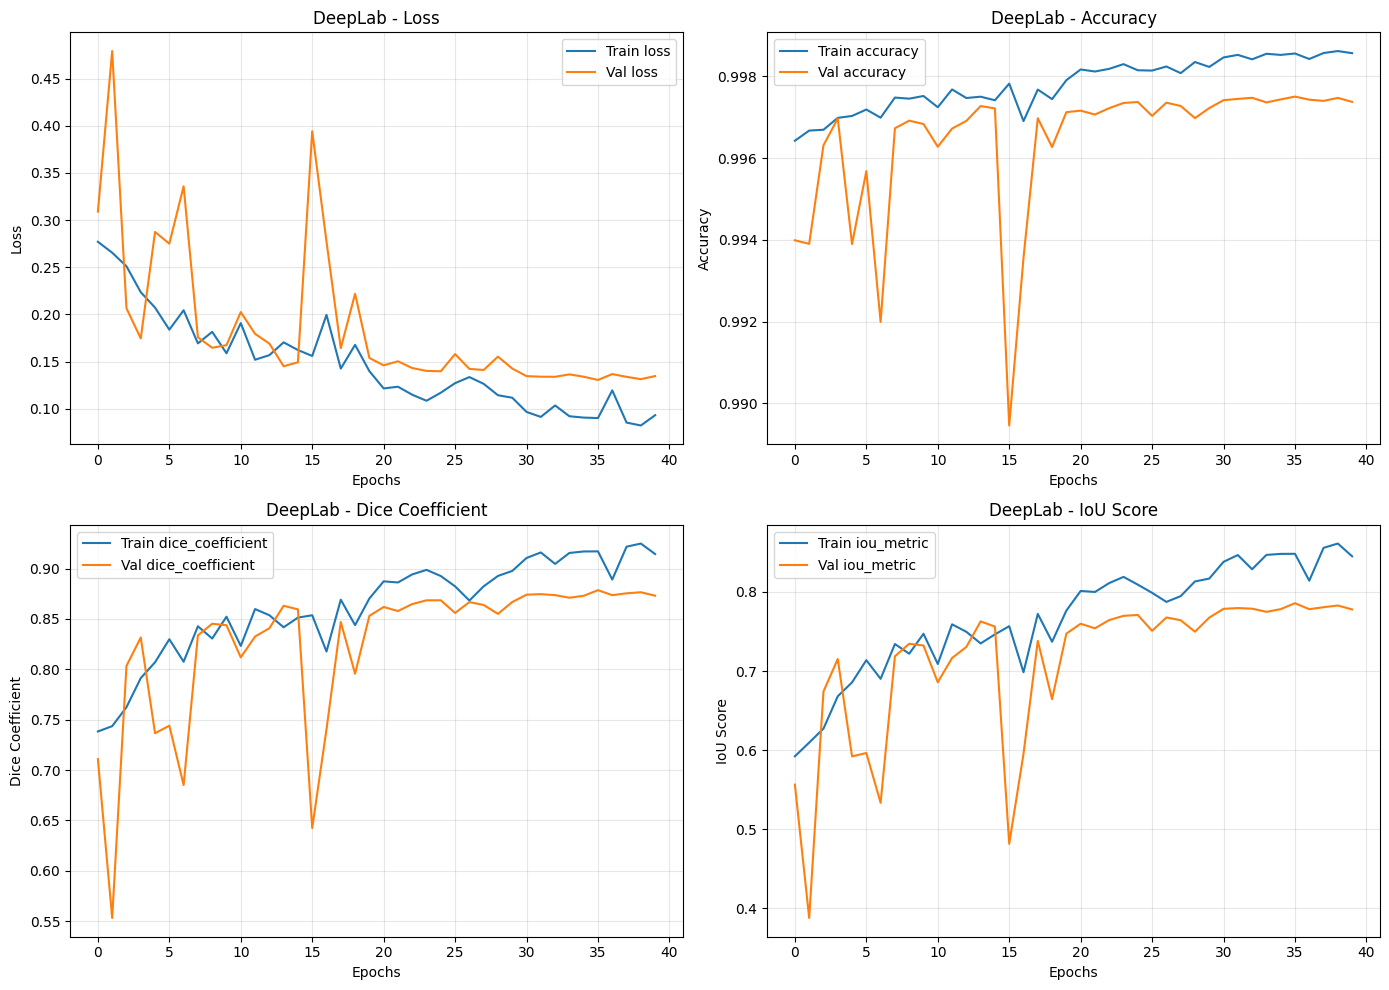

(<Functional name=functional_2, built=True>,
 <keras.src.callbacks.history.History at 0x7a0f8233f020>)

In [31]:
train_model(DeepLab, X_train, y_train, X_val, y_val, model_name='DeepLab', epochs=40, batch_size=16,learning_rate=3e-4)


Evaluating DeepLab...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Precision: 0.8935
Recall: 0.8637
F1-Score: 0.8783
IoU: 0.7830
Dice Coefficient: 0.8783
ROC AUC: 0.9890
PR AUC: 0.9271


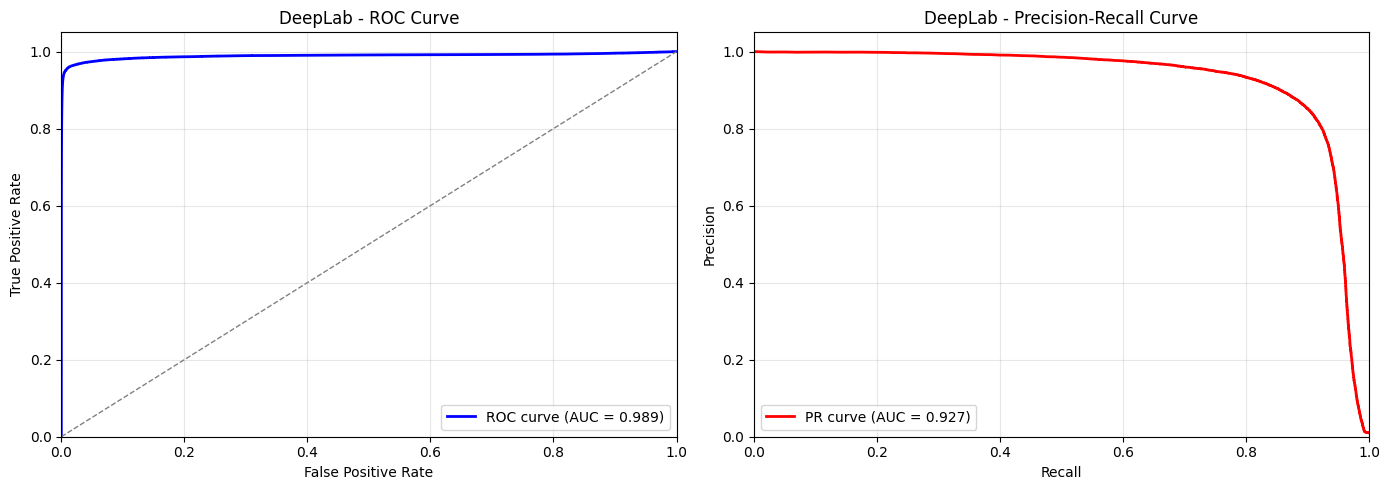

In [35]:
DeepLab_metrics=evaluate_model(DeepLab, X_test, y_test, model_name='DeepLab', plot_curves=True)

In [43]:
def visualize_predictions(model, X_test, y_test, filenames=None, num_samples=5, model_name="Model"):
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(12, num_samples * 4))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_mask = y_test[idx].squeeze()

        # Predict
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred_binary = (pred > 0.5).astype(np.float32).squeeze()

        # Original Image
        plt.subplot(num_samples, 4, 4*i+1)
        plt.imshow(img)
        title = filenames[idx] if filenames else f"Sample {idx}"
        plt.title(f"Original\n{title}")
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 4, 4*i+2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 4, 4*i+3)
        plt.imshow(pred_binary, cmap='gray')
        plt.title(f"{model_name} Prediction")
        plt.axis('off')

        # Overlay Prediction on Image
        plt.subplot(num_samples, 4, 4*i+4)
        plt.imshow(img)
        plt.imshow(pred_binary, cmap='Reds', alpha=0.4)
        plt.title("Prediction Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


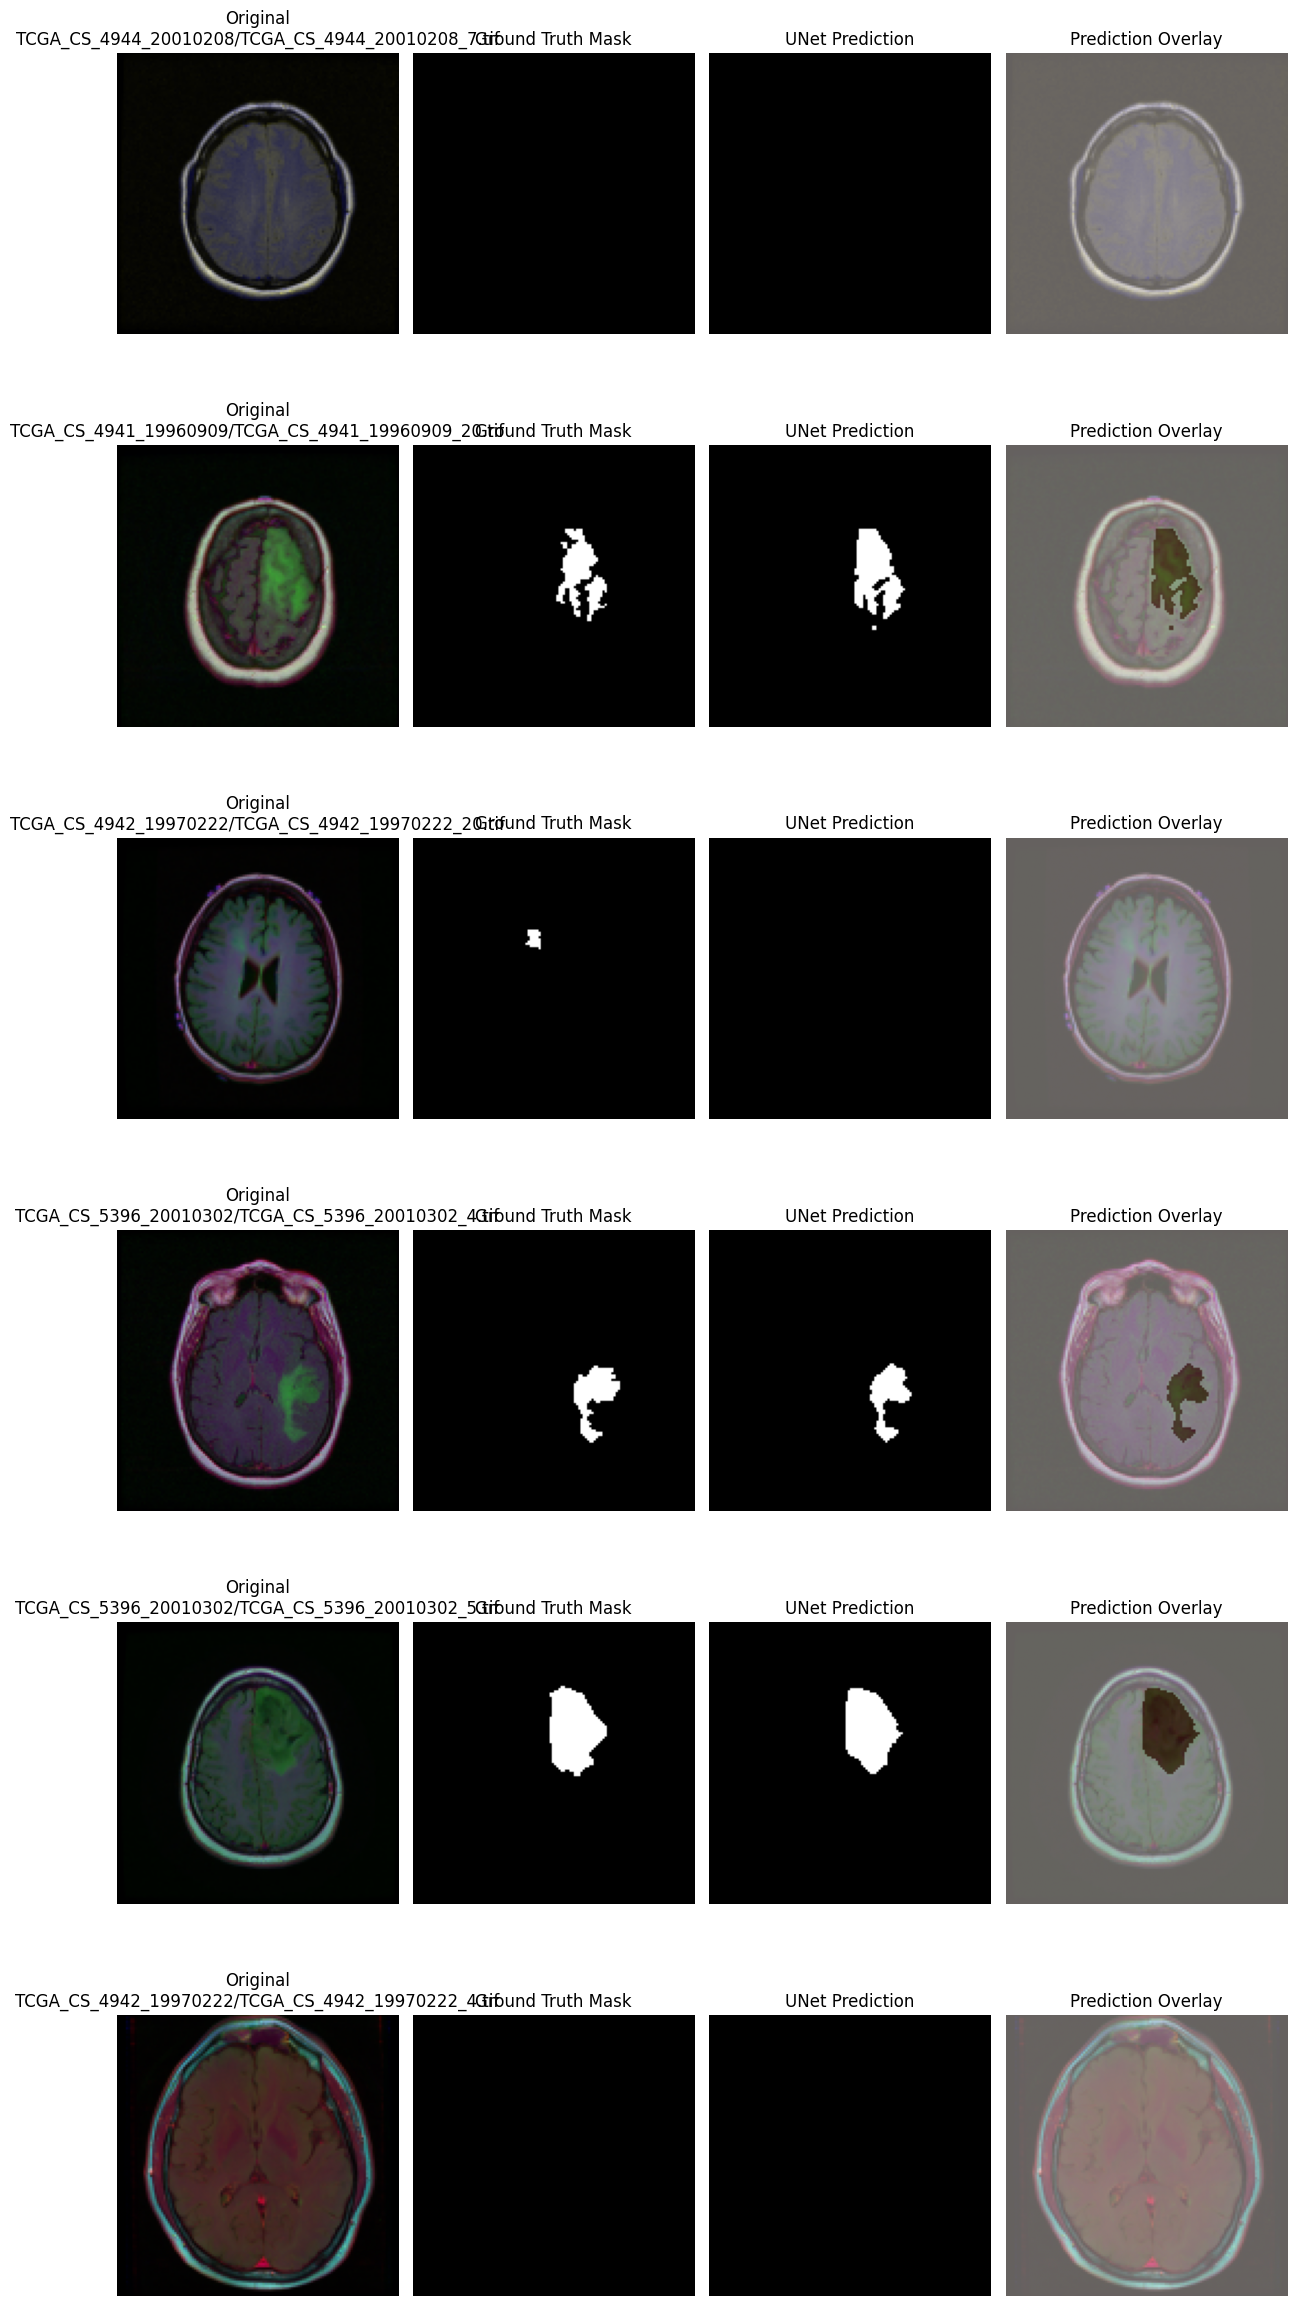

In [49]:
visualize_predictions(uNet, X_test, y_test, filenames, num_samples=6, model_name="UNet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


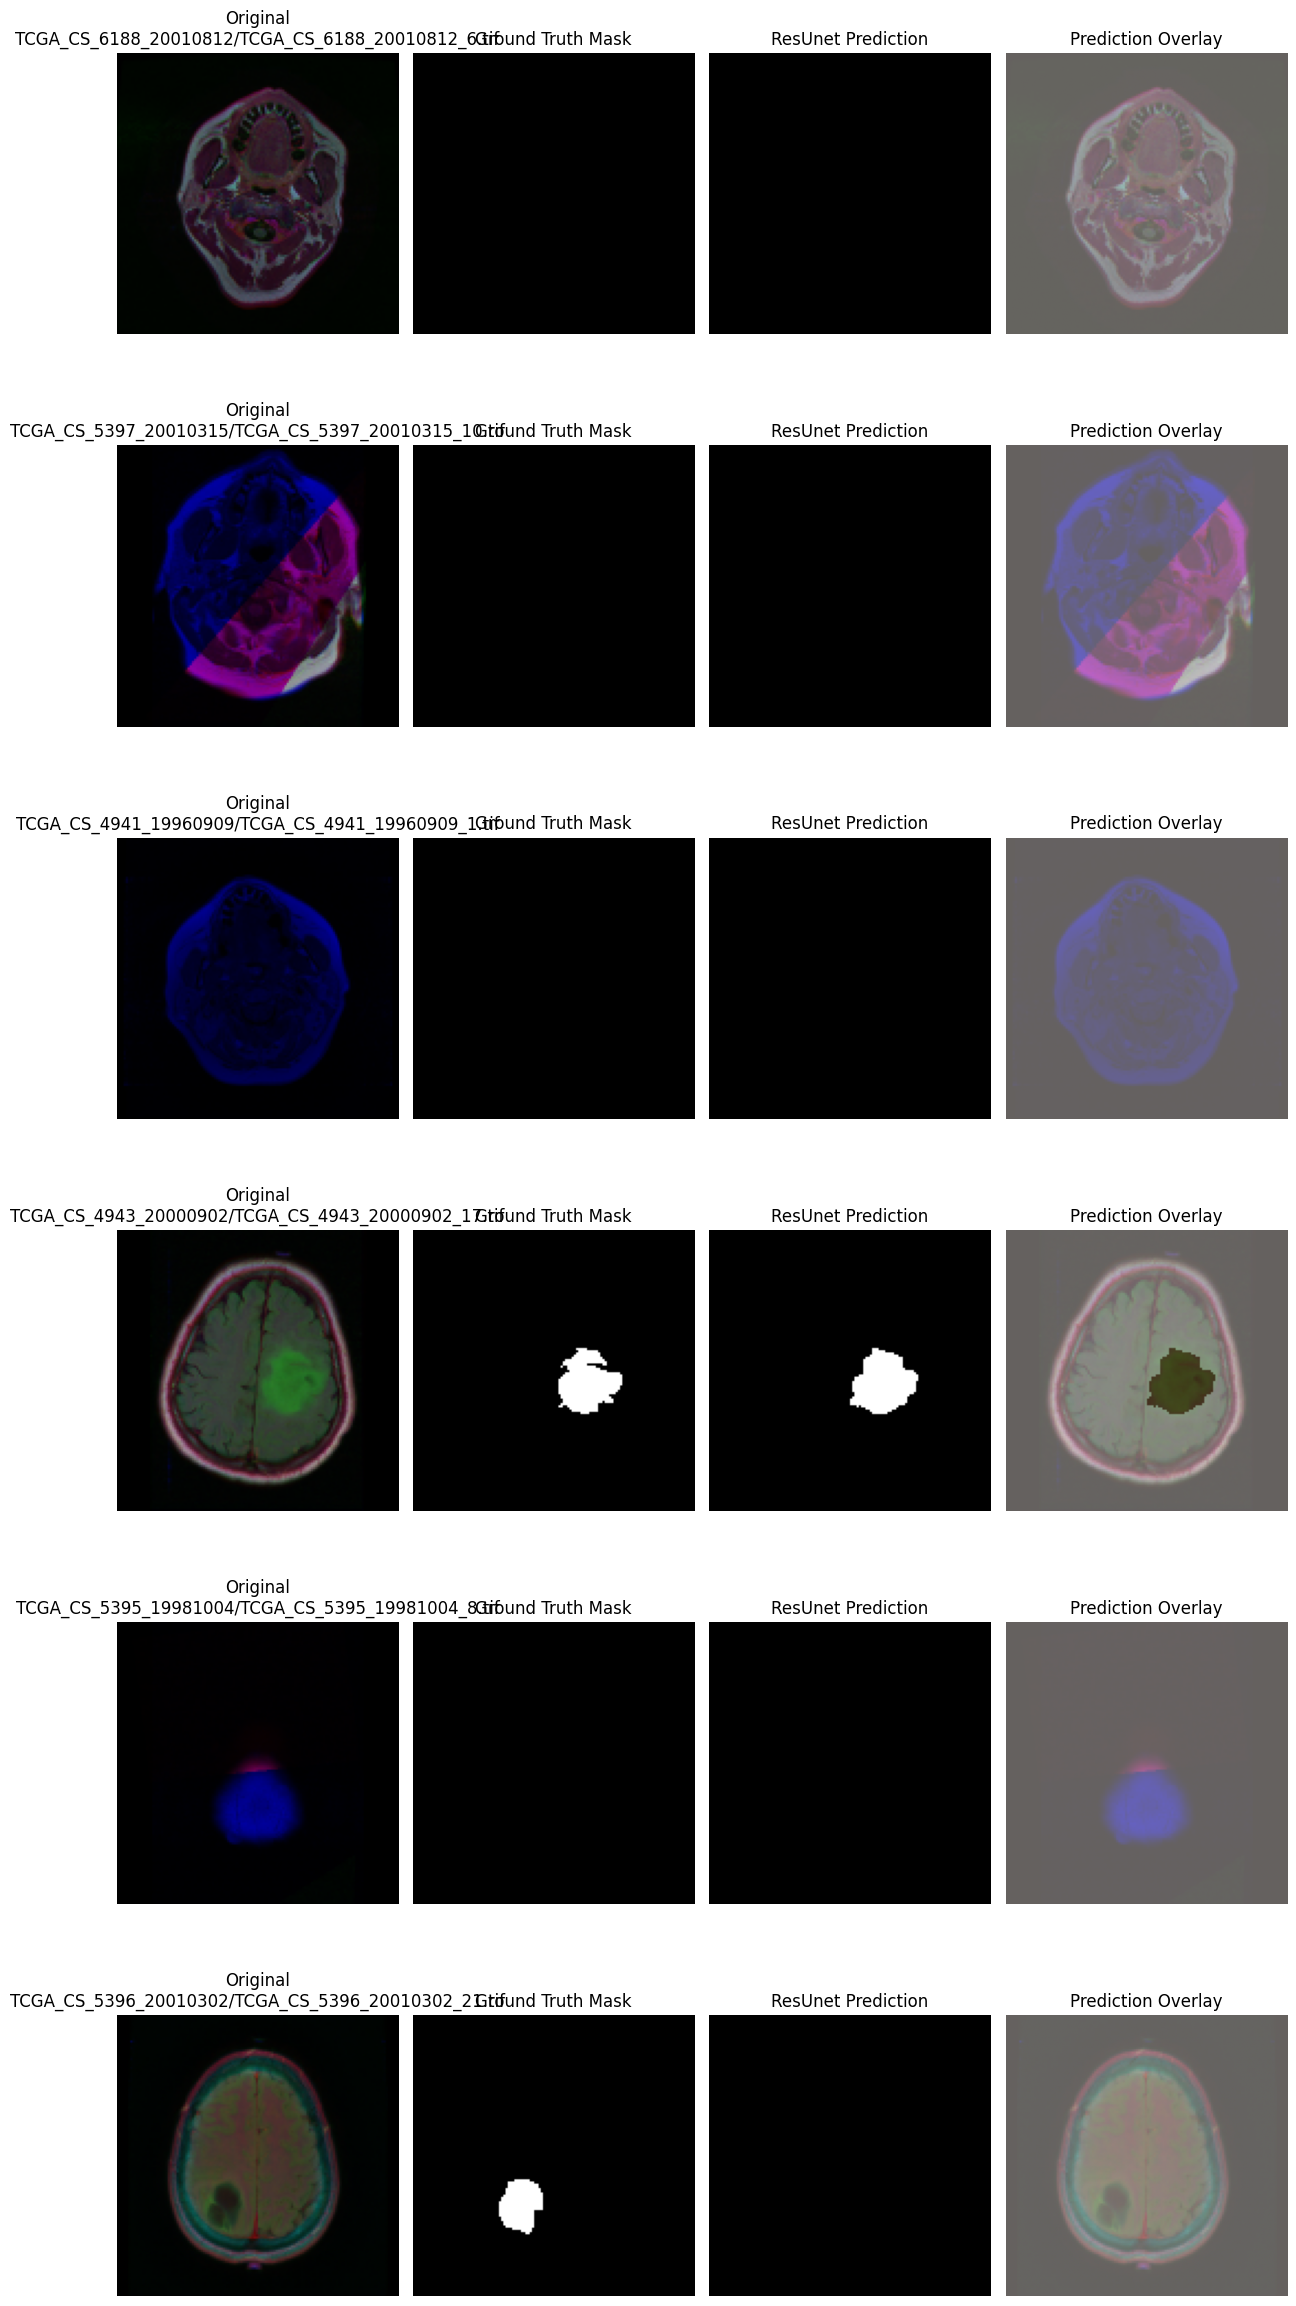

In [46]:
visualize_predictions(ResUnet, X_test, y_test, filenames, num_samples=6, model_name="ResUnet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


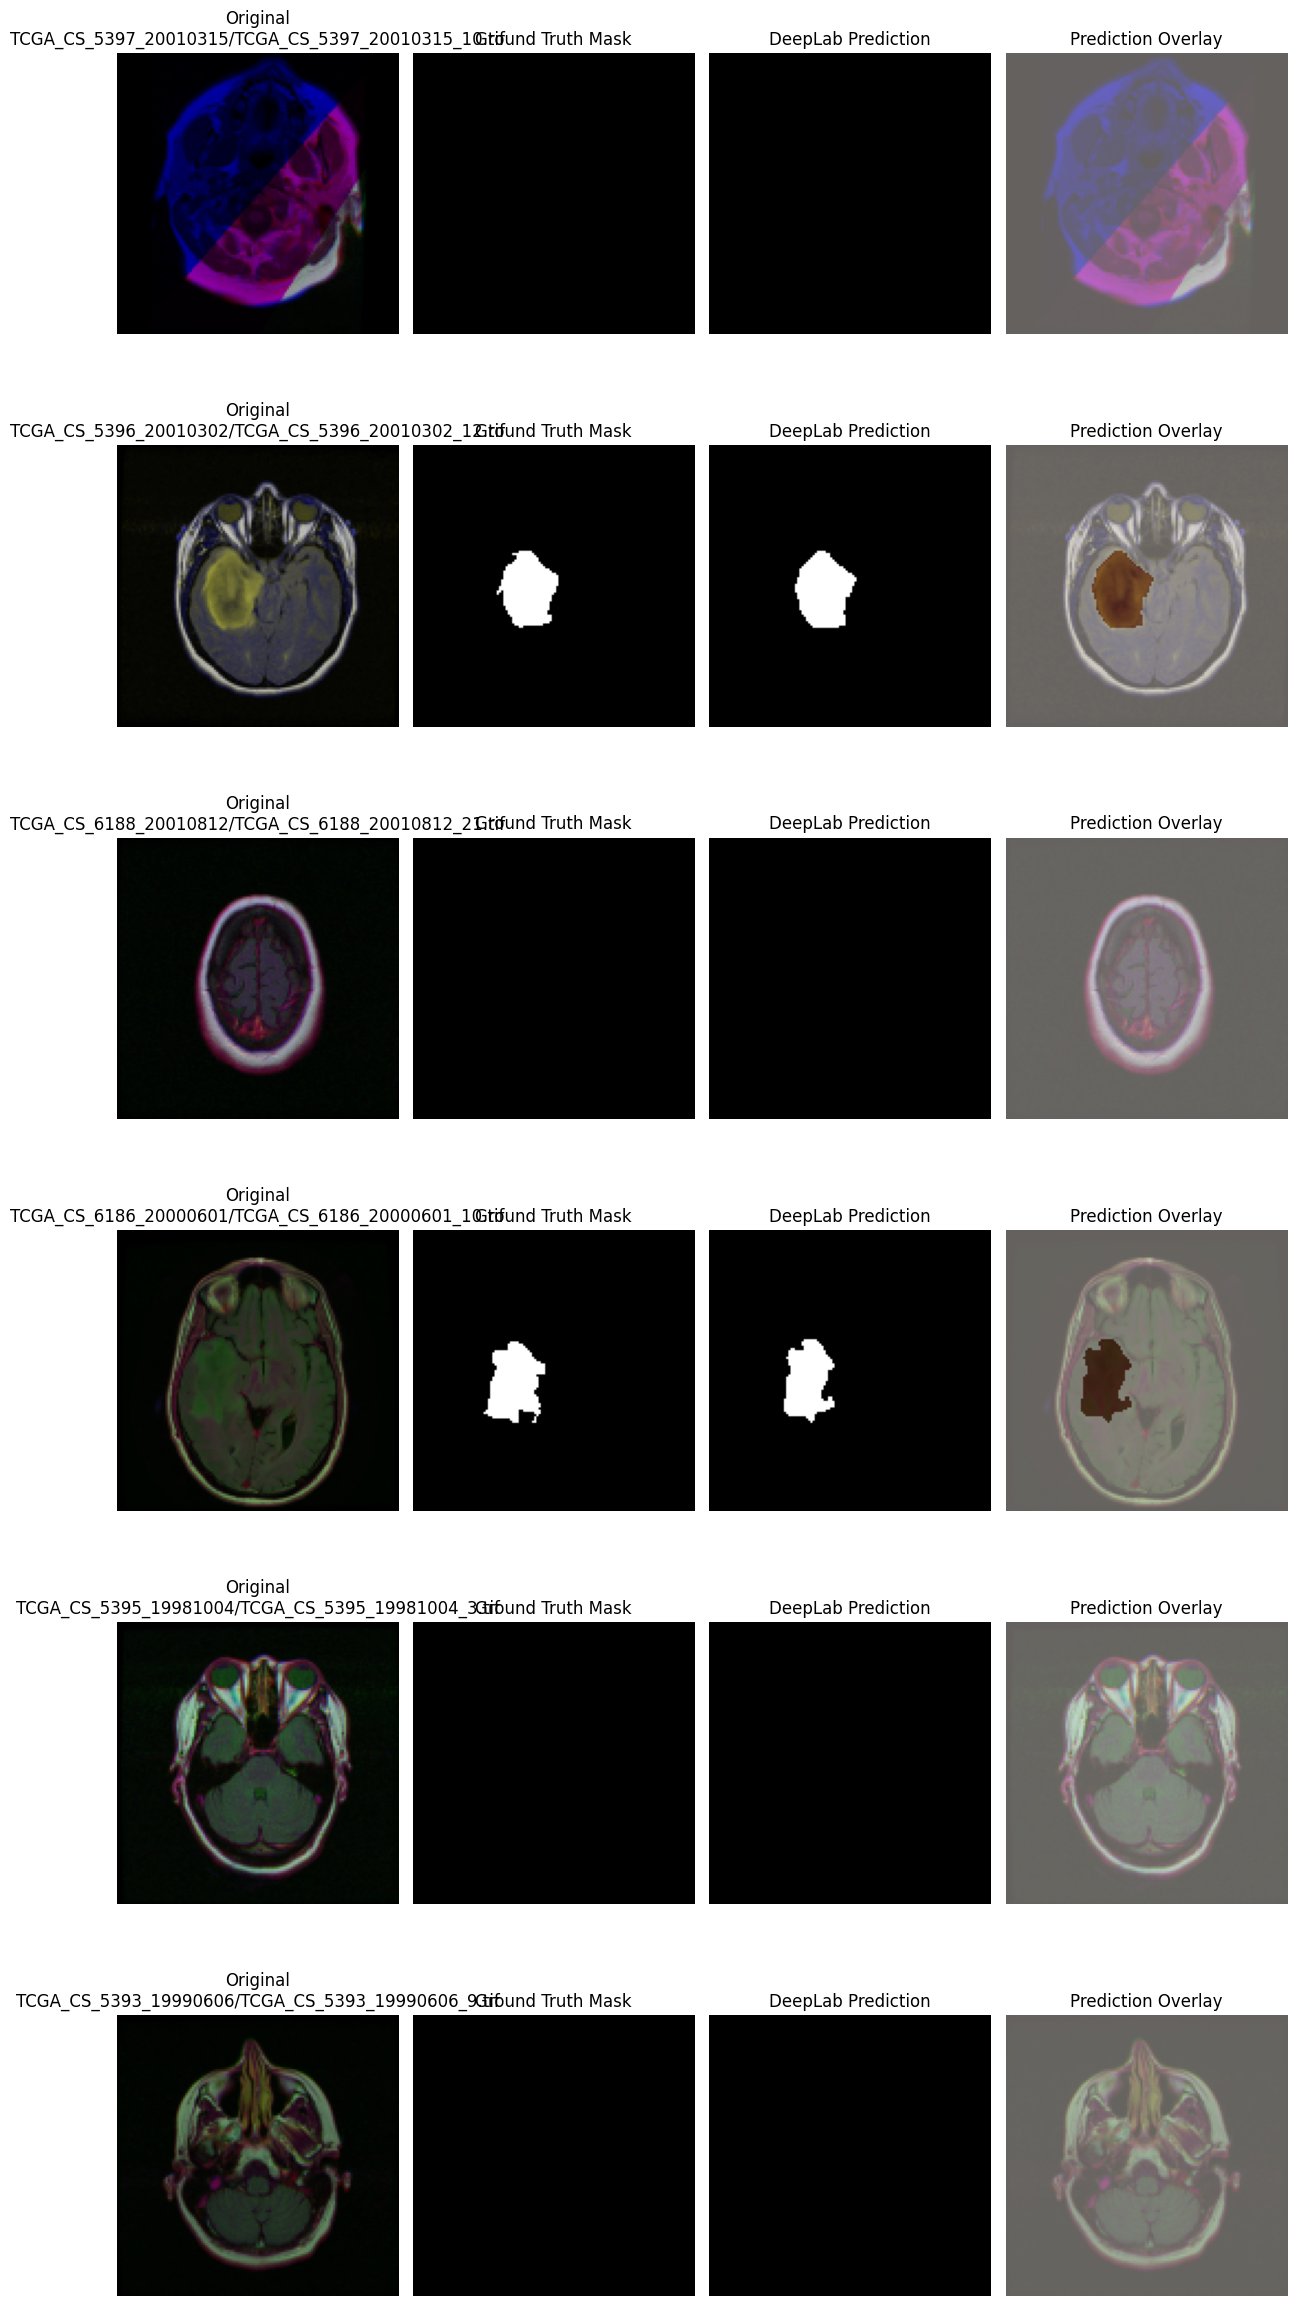

In [48]:
visualize_predictions(DeepLab, X_test, y_test, filenames, num_samples=6, model_name="DeepLab")




In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(unet, resunet, deeplab):
    metrics = ['precision', 'recall', 'f1_score', 'iou', 'dice']
    model_names = ['UNet', 'ResUNet', 'DeepLab']

    data = [
        [unet[m] for m in metrics],
        [resunet[m] for m in metrics],
        [deeplab[m] for m in metrics]
    ]

    x = np.arange(len(metrics))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, data[0], width, label='UNet')
    plt.bar(x, data[1], width, label='ResUNet')
    plt.bar(x + width, data[2], width, label='DeepLab')

    plt.xticks(x, ['Precision', 'Recall', 'F1', 'IoU', 'Dice'])
    plt.ylabel('Score')
    plt.title('Model Performance Comparison on Test Dataset')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


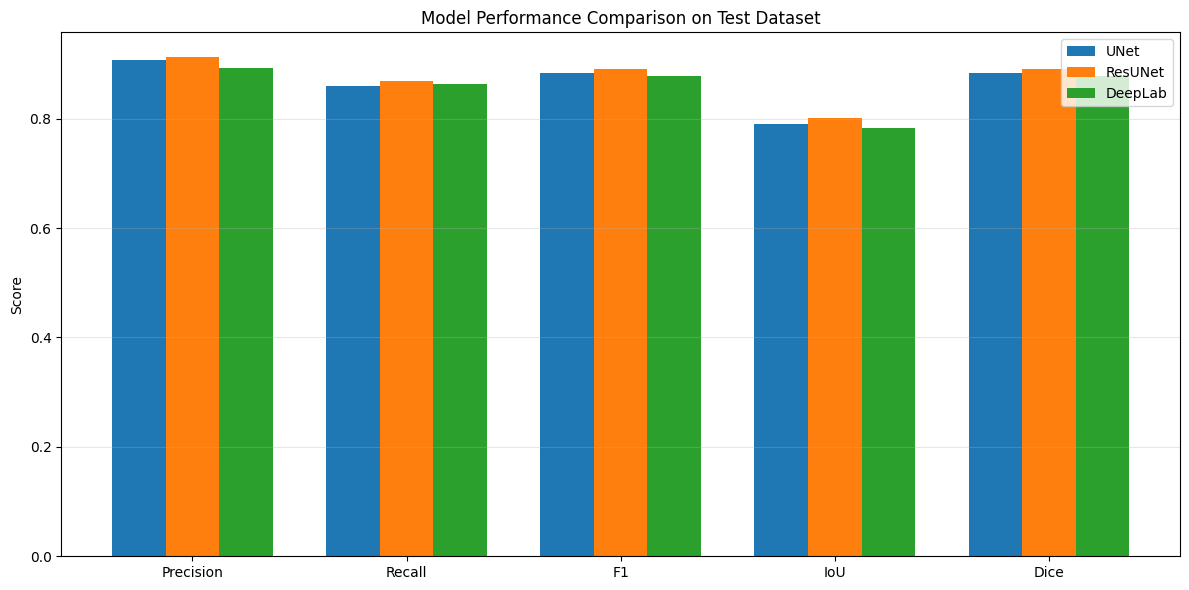

In [38]:
plot_model_comparison(uNet_metrics, ResUnet_metrics, DeepLab_metrics)
